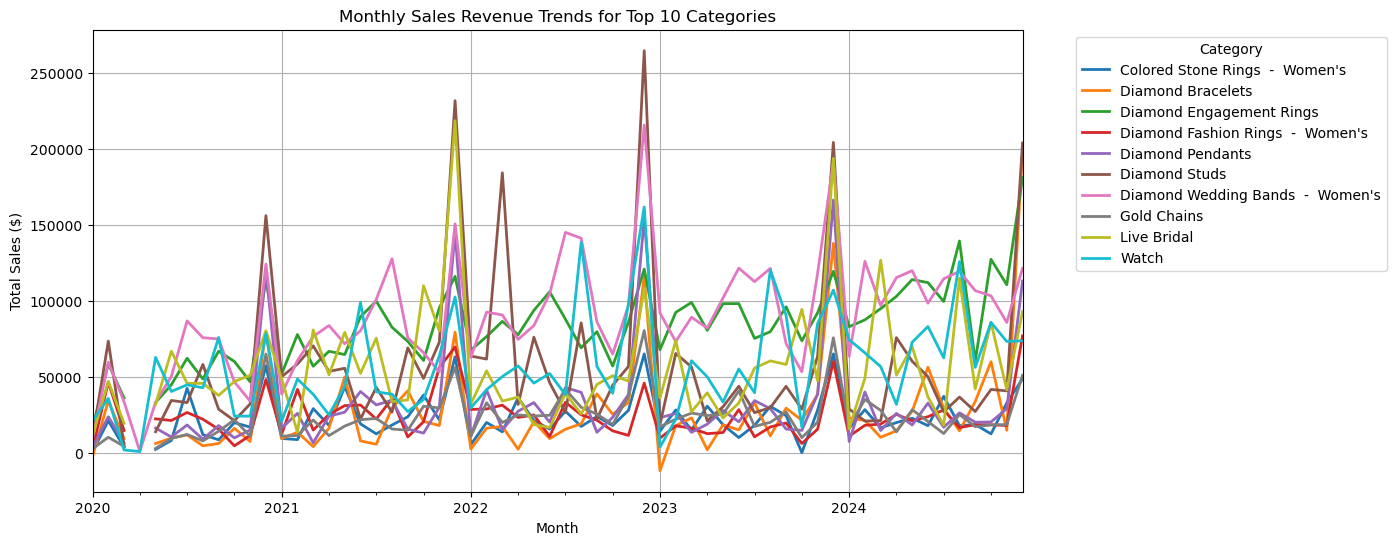

In [36]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np
from scipy.stats import zscore
import plotly.graph_objects as go


# Initialize BigQuery client
client = bigquery.Client()

# Define the query to get monthly sales revenue for the top 10 categories
query = """
WITH top_categories AS (
    SELECT category_name, SUM(sale_total) AS total_sales
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    GROUP BY category_name
    ORDER BY total_sales DESC
    LIMIT 10
)
SELECT 
    DATE_TRUNC(sold_date, MONTH) AS month,
    category_name,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE category_name IN (SELECT category_name FROM top_categories)
GROUP BY month, category_name
ORDER BY month, category_name;
"""

# Run the query
df = client.query(query).to_dataframe()

# Convert month to datetime format
df['month'] = pd.to_datetime(df['month'])

# Pivot for visualization
df_pivot = df.pivot(index="month", columns="category_name", values="total_sales")

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_pivot.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Sales Revenue Trends for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Show plot
plt.show()


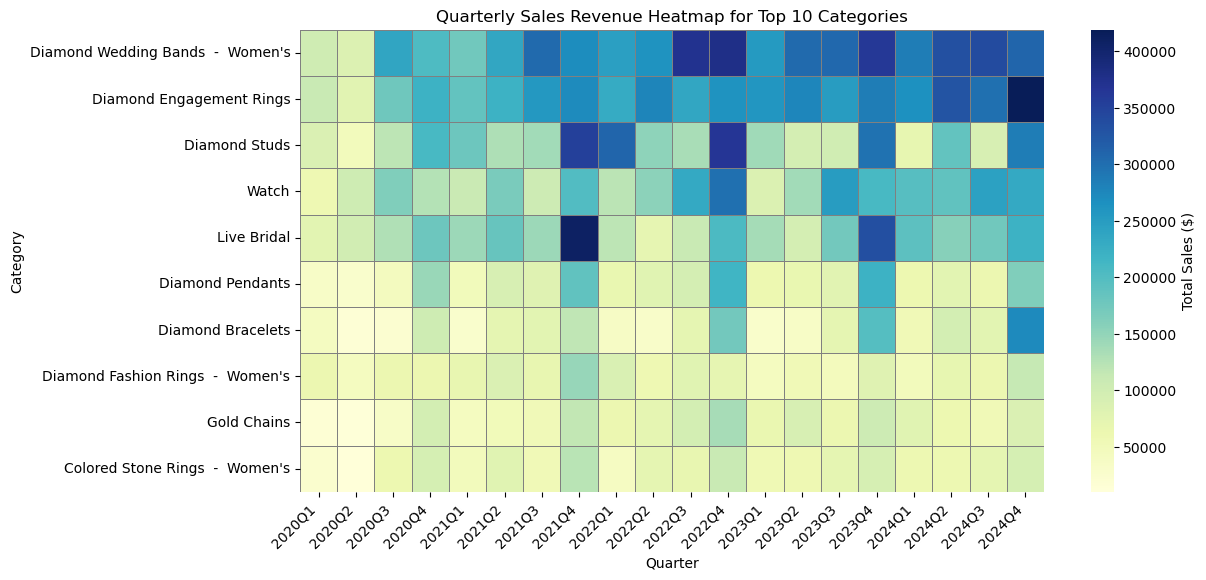

In [37]:
# Convert 'month' column to datetime if not already
df['month'] = pd.to_datetime(df['month'])

# Aggregate to quarterly data
df['quarter'] = df['month'].dt.to_period('Q')
df_quarterly = df.groupby(['quarter', 'category_name'])['total_sales'].sum().reset_index()

# Determine total sales per category for sorting
category_sales_rank = df_quarterly.groupby('category_name')['total_sales'].sum().sort_values(ascending=False).index

# Pivot for heatmap (sorted categories)
df_heatmap = df_quarterly.pivot(index="category_name", columns="quarter", values="total_sales")
df_heatmap = df_heatmap.loc[category_sales_rank]  # Sort categories by total sales

# Set up the figure size
plt.figure(figsize=(12, 6))

# Create heatmap
sns.heatmap(df_heatmap, cmap="YlGnBu", linewidths=0.5, linecolor='gray', cbar_kws={'label': 'Total Sales ($)'})

# Formatting
plt.title("Quarterly Sales Revenue Heatmap for Top 10 Categories")
plt.xlabel("Quarter")
plt.ylabel("Category")

# Rotate x-axis labels for readability
plt.xticks(rotation=45, ha='right')

# Show plot
plt.show()



In [38]:
# Compute z-scores for total_sales within each category
df_quarterly["z_score"] = df_quarterly.groupby("category_name")["total_sales"].transform(zscore)

# Filter for outliers (z-score > 3 or < -3)
df_outliers = df_quarterly[(df_quarterly["z_score"] > 3) | (df_quarterly["z_score"] < -3)]

# Display outliers
print("Identified Outliers (Z-score > 3 or < -3):")
print(df_outliers[["quarter", "category_name", "total_sales", "z_score"]])


Identified Outliers (Z-score > 3 or < -3):
   quarter                      category_name  total_sales   z_score
73  2021Q4  Diamond Fashion Rings  -  Women's    146005.35  3.123162
78  2021Q4                        Live Bridal    408630.14  3.008939


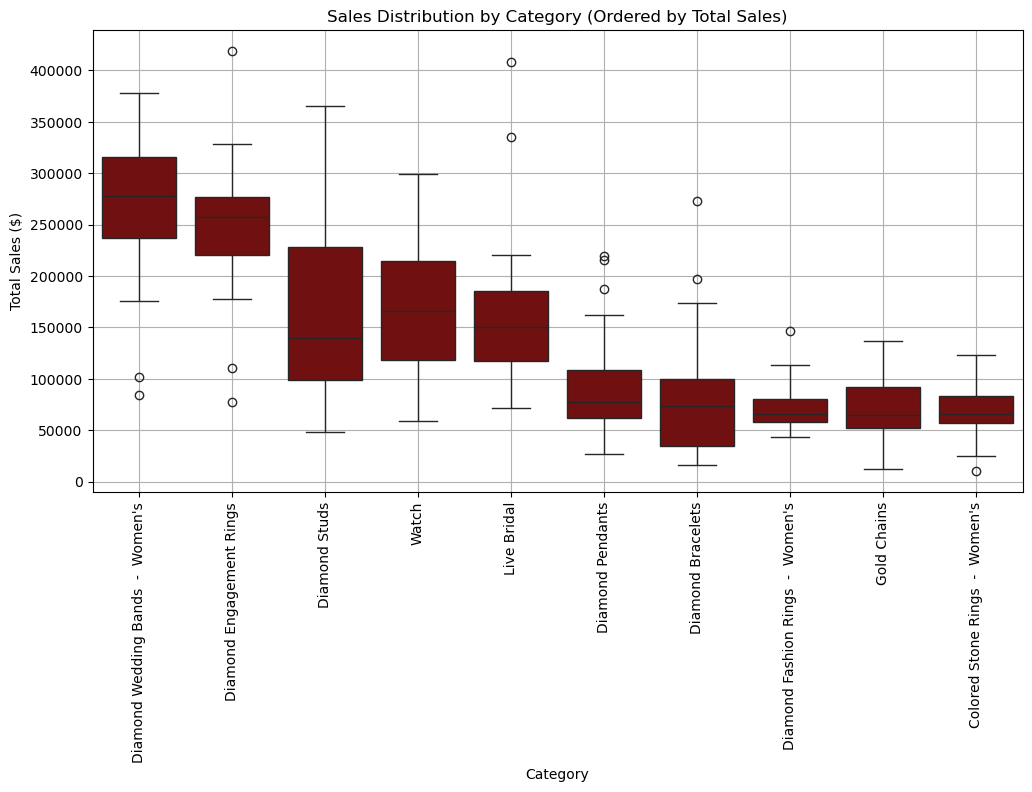

Identified Outliers (Z-score > 3 or < -3):
   quarter                      category_name  total_sales   z_score
73  2021Q4  Diamond Fashion Rings  -  Women's    146005.35  3.123162
78  2021Q4                        Live Bridal    408630.14  3.008939


In [39]:
# Compute total sales per category for sorting
category_sales_rank = df_quarterly.groupby("category_name")["total_sales"].sum().sort_values(ascending=False).index

# Set category order based on total sales
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="category_name",
    y="total_sales",
    data=df_quarterly,
    order=category_sales_rank,
    color="maroon"  # Set box color to maroon
)

# Formatting
plt.xticks(rotation=90)
plt.title("Sales Distribution by Category (Ordered by Total Sales)")
plt.xlabel("Category")
plt.ylabel("Total Sales ($)")
plt.grid(True)

# Show plot
plt.show()

# Display outliers
print("Identified Outliers (Z-score > 3 or < -3):")
print(df_outliers[["quarter", "category_name", "total_sales", "z_score"]])


### Identifying Key Trends:
#### Top-Selling Categories:
Women's Diamond Wedding Bands and Diamond Engagement Rings have the highest median sales and significant variability. These categories are contributing the most to overall revenue.

#### Mid-Range Performers:
Diamond Studs, Watches, Live Bridal, and Diamond Pendants also have high median sales, but with more spread (variation) between quarters.

#### Lower-Selling Categories:
Gold Chains, Women's Diamond Fashion Rings and Women's Colored Stone Rings have the lowest median sales, meaning they contribute less to total revenue of the top 10 categories.

### Understanding Oultiers & Variability:
#### Large Spreads (High Variability in Sales)
- Diamond Studs, Watches, and Live Bridal show larger interquartile ranges (IQRs), indicating fluctuating demand between quarters.
- These categories may be harder to forecast because their sales are less consistent.
#### Frequent Outliers (Spikes in Sales)
- Outliers (points above the whiskers) suggest quarters where sales surged unexpectedly.
- Women's Diamond Wedding Bands, Diamond Engagement Rings and Watches show several high ouliers, like due to seasonal spikes, e.g. holiday shopping in Q4.
#### Consisten Performers (Lower Variability)
- Gold Chains and Women's Colored Stone Rings have smaller IQRs, meaning their sales are more stable over time.
- these categories are likely easier to forecast,

### Interpreting the Identified Outlier:
The Z-score analysis flagged Q4 2021 for "Diamond Fashion Rings - Women's" as a statistical outlier.

#### What does this mean? 
- Q4 2021 (October-December '21)
- Category: Women's Diamond Fashion Rings
- Total Sales: $146,005.35
- Z-score: 3.04 - This means the sales in this quarter were more than 3 standard deviations above the mean for this category.

#### Why is this an outlier?
- A Z-score above 3 indicates that this sales value is significantly higher than the typical sales for this cateory.
- This suggests a spike in demand that is not consistent with previous quarters.

#### Possible reasons for the spike?
- Historically strong quarter for jewelry sales due to the holidays (Black Friday, Christmas, engagement season).
- Economic Factors - did consumer spending on luxury items increase in late 2021?
- One-off Large Purchases? A few high-value transactions could have pushed up sales.

#### Impact on Forecasting:
- Adjust for Seasonality: If this spike is seasonal, the model should incorporate seasonality.
- Handle Anomalies Carefully: If this was a one-time event, using raw historial data could lead to overestimated forecasts.
- Compare to Other Q4s: Checking sales for Q4 in other years will help determine if htis is a recurring trend or a true anomaly.

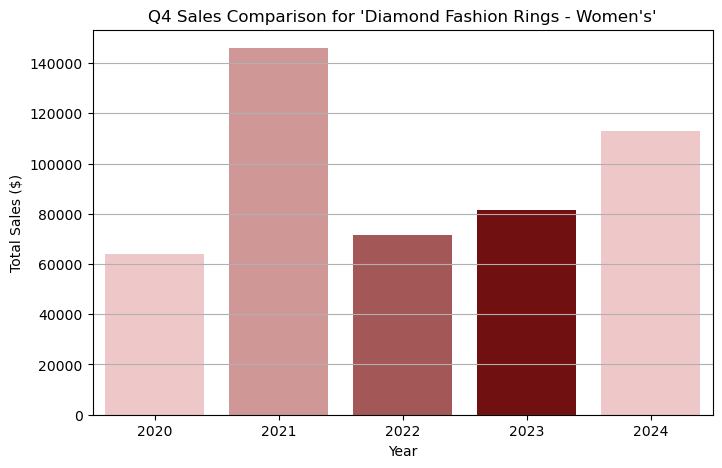

   year                      category_name  total_sales
0  2020  Diamond Fashion Rings  -  Women's     64099.11
1  2021  Diamond Fashion Rings  -  Women's    146005.35
2  2022  Diamond Fashion Rings  -  Women's     71621.20
3  2023  Diamond Fashion Rings  -  Women's     81537.60
4  2024  Diamond Fashion Rings  -  Women's    113159.47


In [40]:
query = """
SELECT 
    year,
    category_name,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE quarter LIKE 'Oct%'
AND category_name = "Diamond Fashion Rings  -  Women's"  -- Using double quotes
GROUP BY year, category_name
ORDER BY year;
"""

# Run the query
df_q4_comparison = client.query(query).to_dataframe()

# Define a custom maroon gradient palette
maroon_palette = ["#f4c2c2", "#d98e8e", "#b04a4a", "#800000"]  # Light to dark maroon

# Make sure the number of colors matches the number of years
unique_years = sorted(df_q4_comparison["year"].unique())
palette_dict = {year: maroon_palette[i % len(maroon_palette)] for i, year in enumerate(unique_years)}

# Plot Q4 sales comparison over years
plt.figure(figsize=(8, 5))
sns.barplot(
    x="year",
    y="total_sales",
    hue="year",
    data=df_q4_comparison,
    palette=palette_dict,
    legend=False
)

# Formatting
plt.title("Q4 Sales Comparison for 'Diamond Fashion Rings - Women's'")
plt.xlabel("Year")
plt.ylabel("Total Sales ($)")
plt.grid(axis="y")

# Show plot
plt.show()

# Display the Q4 sales comparison data
print(df_q4_comparison)



### Key Takeaways
#### Biggest Spike: Q4 2021 ($146,005.35)
- Q4 2021 stands out as an anomaly, with significantly higher sales compared to other years.
- This supports our earlier Z-score analysis that flagged it as an outlier.
#### Post-2021 Dip & Recovery:
- Sales dropped sharply in 2022 ($71,621.20) after the 2021 spike.
- Sales recovered in 2023 ($81,537.60) and jumped again in 2024 ($113,159.47).

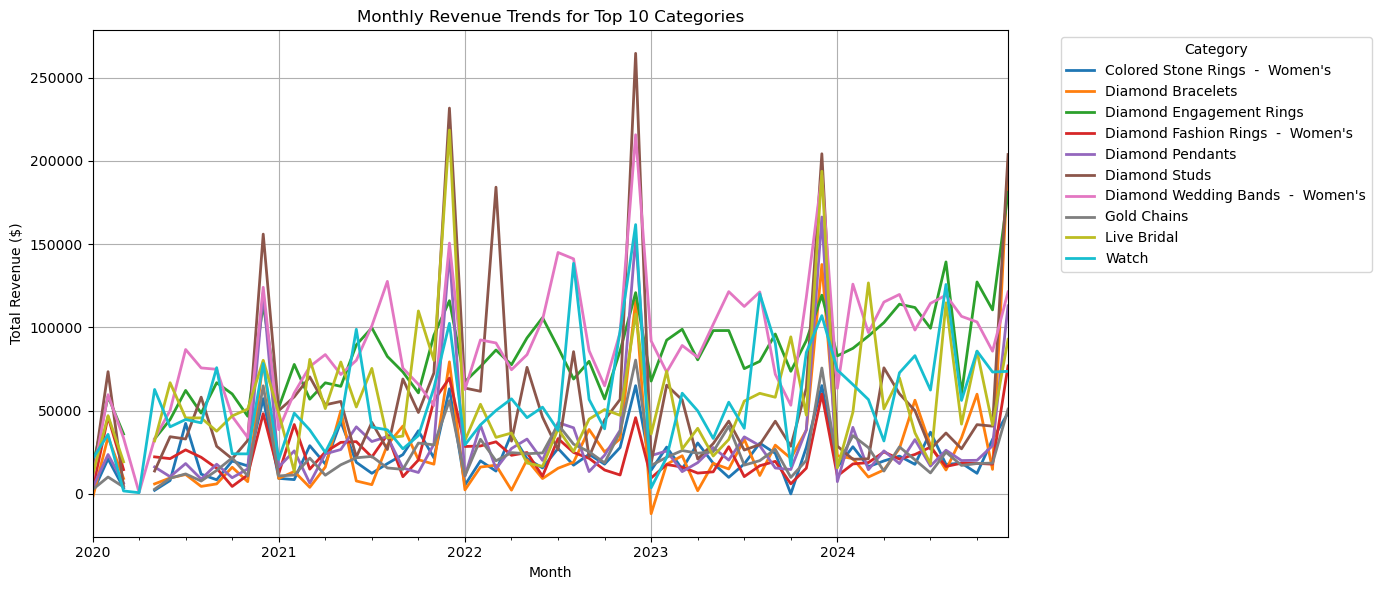

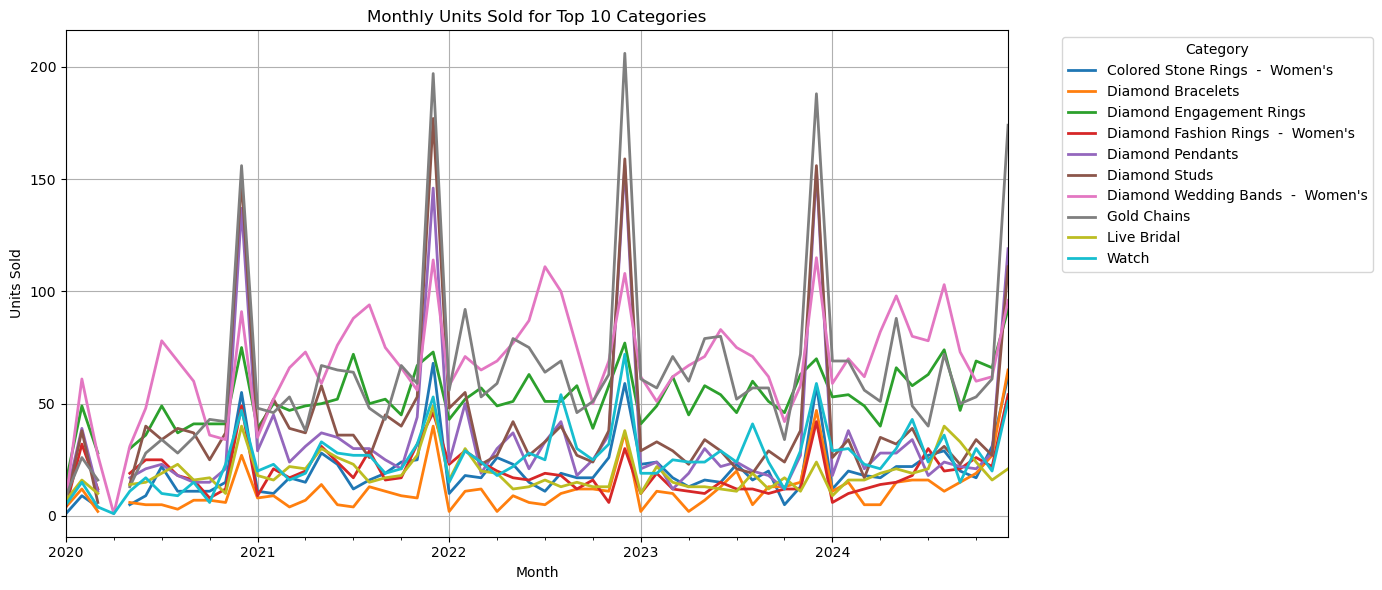

In [41]:
# Block 6
# Query definition
query = """
WITH top_categories AS (
  SELECT category_name
  FROM (
    SELECT category_name, SUM(sale_total) AS total_sales
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE sold_date BETWEEN '2020-01-01' AND '2024-12-31'
    GROUP BY category_name
    ORDER BY total_sales DESC
    LIMIT 10
  )
)

SELECT
  DATE_TRUNC(sold_date, MONTH) AS month,
  category_name,
  COUNT(DISTINCT sku) AS items_sold,
  ROUND(SUM(sale_total), 2) AS total_revenue
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date BETWEEN '2020-01-01' AND '2024-12-31'
  AND category_name IN (SELECT category_name FROM top_categories)
GROUP BY month, category_name
ORDER BY month, category_name;
"""

df = client.query(query).to_dataframe()

# Convert 'month' column to datetime
df['month'] = pd.to_datetime(df['month'])

# Create pivot tables for each metric
df_pivot_revenue = df.pivot(index='month', columns='category_name', values='total_revenue')
df_pivot_units = df.pivot(index='month', columns='category_name', values='items_sold')

# ---- Plot 1: Monthly Revenue Trends ----
plt.figure(figsize=(14, 6))
df_pivot_revenue.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Revenue Trends for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot 2: Monthly Units Sold Trends ----
plt.figure(figsize=(14, 6))
df_pivot_units.plot(ax=plt.gca(), linewidth=2)
plt.title("Monthly Units Sold for Top 10 Categories")
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

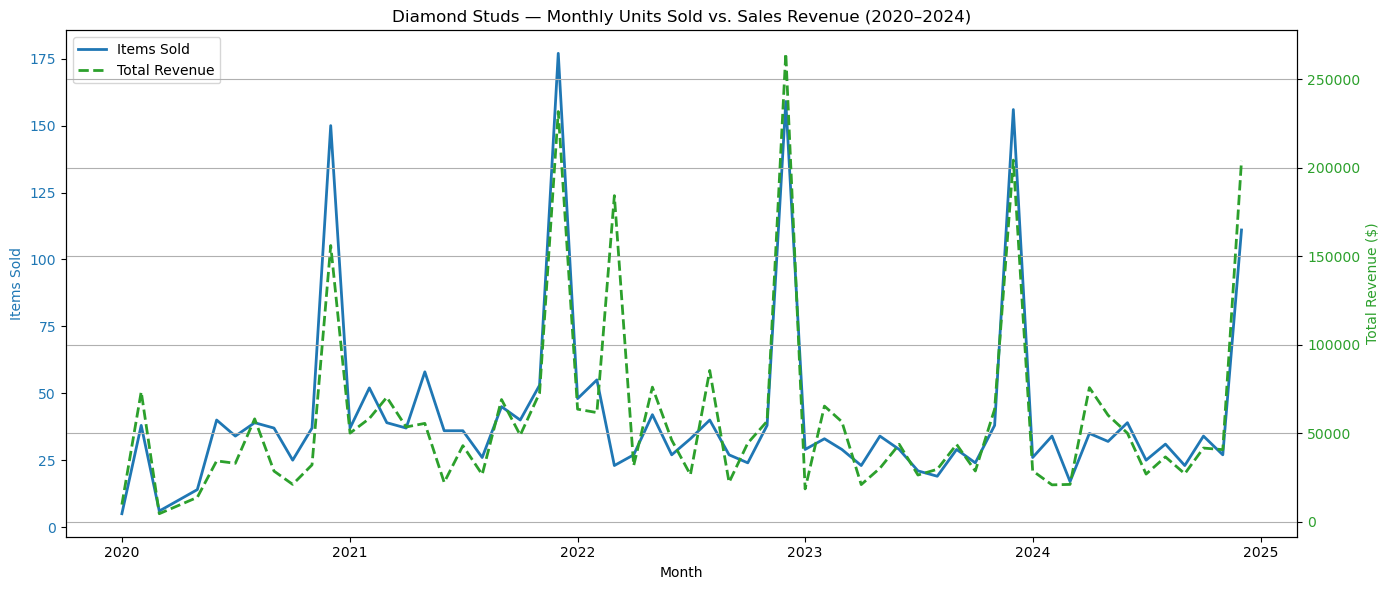

In [42]:
# Block 7
# Filter to just one category
category_name = "Diamond Studs"
df_filtered = df[df['category_name'] == category_name].copy()
df_filtered['month'] = pd.to_datetime(df_filtered['month'])

# Sort by month in case it's not sorted
df_filtered = df_filtered.sort_values('month')

# Set up dual-axis plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot items sold (left y-axis)
color = 'tab:blue'
ax1.set_xlabel("Month")
ax1.set_ylabel("Items Sold", color=color)
ax1.plot(df_filtered['month'], df_filtered['items_sold'], color=color, label='Items Sold', linewidth=2)
ax1.tick_params(axis='y', labelcolor=color)

# Create right y-axis for revenue
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Total Revenue ($)", color=color)
ax2.plot(df_filtered['month'], df_filtered['total_revenue'], color=color, linestyle='dashed', label='Total Revenue', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)

# Title and formatting
plt.title(f"{category_name} — Monthly Units Sold vs. Sales Revenue (2020–2024)")
fig.tight_layout()

# Optional combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.grid(True)
plt.show()

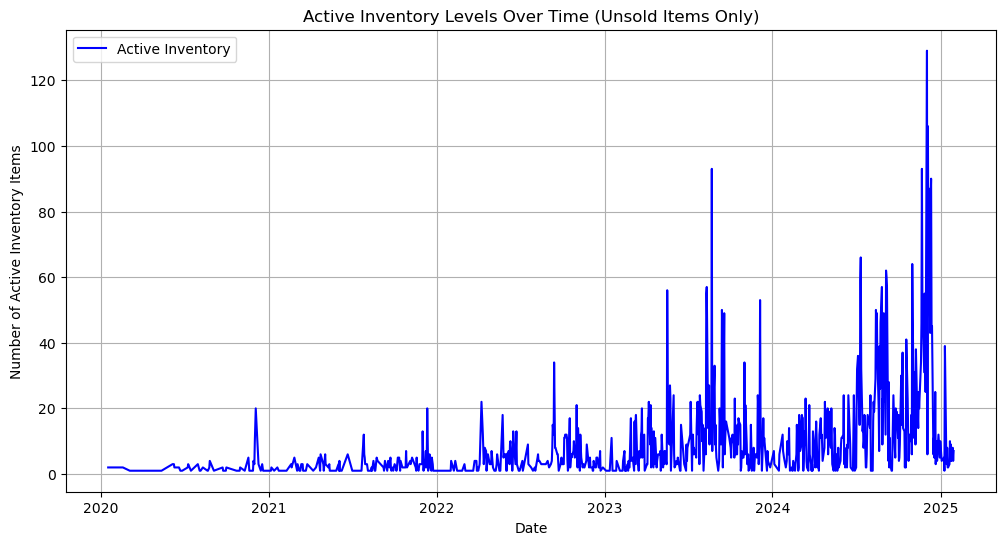

In [43]:
# Block 8
# Query to fetch active inventory over time (only unsold items)
query = """
SELECT 
    DATE(purchase_date) AS date,
    COUNT(sku) AS active_inventory_count
FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
WHERE sold_status = 0  -- Only count inventory still in stock
AND purchase_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query
df_active_inventory = client.query(query).to_dataframe()

# Convert 'date' to datetime format
df_active_inventory['date'] = pd.to_datetime(df_active_inventory['date'])

# Plot the active inventory levels over time
plt.figure(figsize=(12, 6))
plt.plot(df_active_inventory['date'], df_active_inventory['active_inventory_count'], color='b', label="Active Inventory")

# Formatting the plot
plt.xlabel("Date")
plt.ylabel("Number of Active Inventory Items")
plt.title("Active Inventory Levels Over Time (Unsold Items Only)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

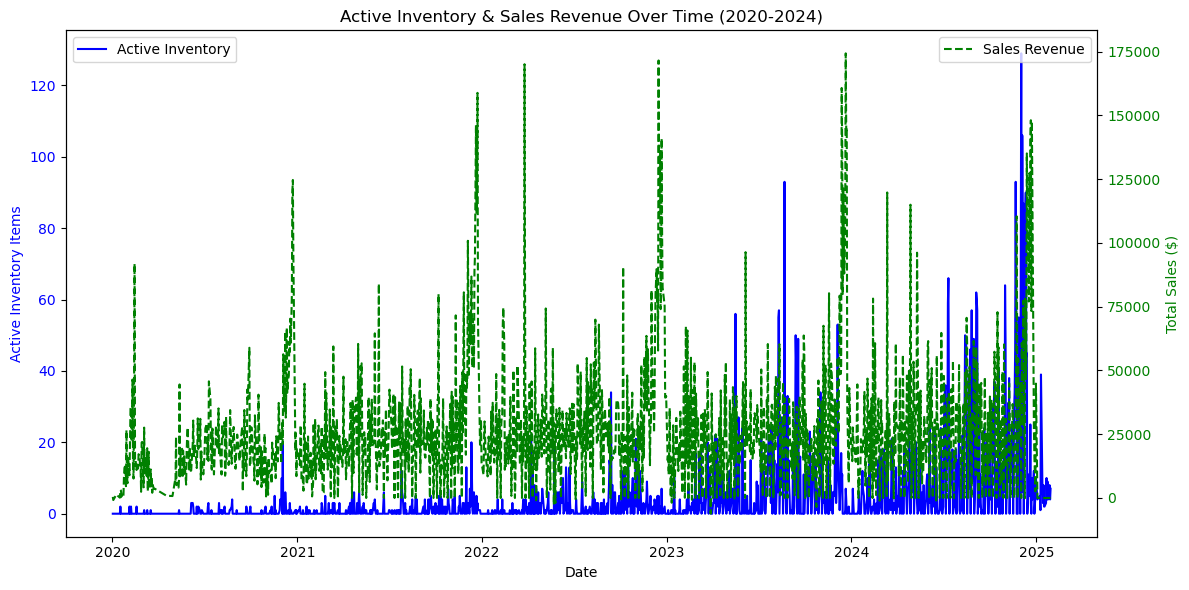

In [44]:
# Block 9
# Query to fetch sales revenue over time
query_sales = """
SELECT 
    DATE(sold_date) AS date,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""


# Run the query for sales
df_sales = client.query(query_sales).to_dataframe()

# Convert 'date' to datetime format
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Merge sales and active inventory data on 'date'
df_inventory_sales = pd.merge(df_active_inventory, df_sales, on='date', how='outer').fillna(0)

# Plot the active inventory levels and sales trends
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Active Inventory (Left Y-Axis)
ax1.set_xlabel("Date")
ax1.set_ylabel("Active Inventory Items", color="b")
ax1.plot(df_inventory_sales['date'], df_inventory_sales['active_inventory_count'], color="b", label="Active Inventory")
ax1.tick_params(axis="y", labelcolor="b")

# Plot Sales Revenue (Right Y-Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Total Sales ($)", color="g")
ax2.plot(df_inventory_sales['date'], df_inventory_sales['total_sales'], color="g", linestyle="dashed", label="Sales Revenue")
ax2.tick_params(axis="y", labelcolor="g")

# Title and legend
plt.title("Active Inventory & Sales Revenue Over Time (2020-2024)")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()


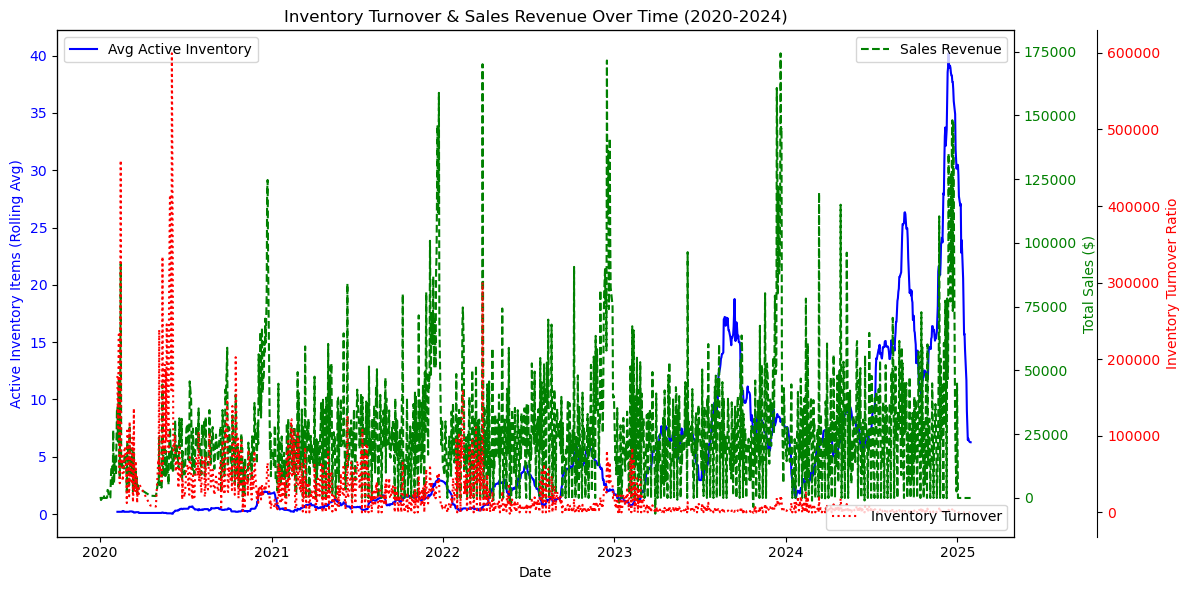

In [45]:
# Block 10
# Query to fetch sales revenue over time
query_sales = """
SELECT 
    DATE(sold_date) AS date,
    SUM(sale_total) AS total_sales
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE sold_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for sales
df_sales = client.query(query_sales).to_dataframe()
df_sales['date'] = pd.to_datetime(df_sales['date'])

# Query to fetch cumulative active inventory levels over time
query_inventory = """
SELECT 
    DATE(purchase_date) AS date,
    SUM(CASE WHEN sold_status = 0 THEN 1 ELSE 0 END) AS active_inventory_count
FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
WHERE purchase_date >= '2020-01-01'  -- Limit to 2020-2024 data
GROUP BY date
ORDER BY date;
"""

# Run the query for active inventory
df_active_inventory = client.query(query_inventory).to_dataframe()
df_active_inventory['date'] = pd.to_datetime(df_active_inventory['date'])

# Merge sales and active inventory data on 'date'
df_inventory_sales = pd.merge(df_active_inventory, df_sales, on='date', how='outer').fillna(0)

# **Compute a Rolling 30-Day Average for Active Inventory**
df_inventory_sales['avg_active_inventory'] = df_inventory_sales['active_inventory_count'].rolling(window=30).mean()

# **Calculate Inventory Turnover Ratio**
df_inventory_sales['inventory_turnover'] = df_inventory_sales['total_sales'] / df_inventory_sales['avg_active_inventory']

# Plot the active inventory levels, sales trends, and inventory turnover
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Active Inventory (Left Y-Axis)
ax1.set_xlabel("Date")
ax1.set_ylabel("Active Inventory Items (Rolling Avg)", color="b")
ax1.plot(df_inventory_sales['date'], df_inventory_sales['avg_active_inventory'], color="b", label="Avg Active Inventory")
ax1.tick_params(axis="y", labelcolor="b")

# Plot Sales Revenue (Right Y-Axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Total Sales ($)", color="g")
ax2.plot(df_inventory_sales['date'], df_inventory_sales['total_sales'], color="g", linestyle="dashed", label="Sales Revenue")
ax2.tick_params(axis="y", labelcolor="g")

# Plot Inventory Turnover (Dashed Line)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("outward", 60))  # Offset third y-axis
ax3.set_ylabel("Inventory Turnover Ratio", color="r")
ax3.plot(df_inventory_sales['date'], df_inventory_sales['inventory_turnover'], color="r", linestyle="dotted", label="Inventory Turnover")
ax3.tick_params(axis="y", labelcolor="r")

# Title and legend
plt.title("Inventory Turnover & Sales Revenue Over Time (2020-2024)")
fig.tight_layout()
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# Show the plot
plt.show()


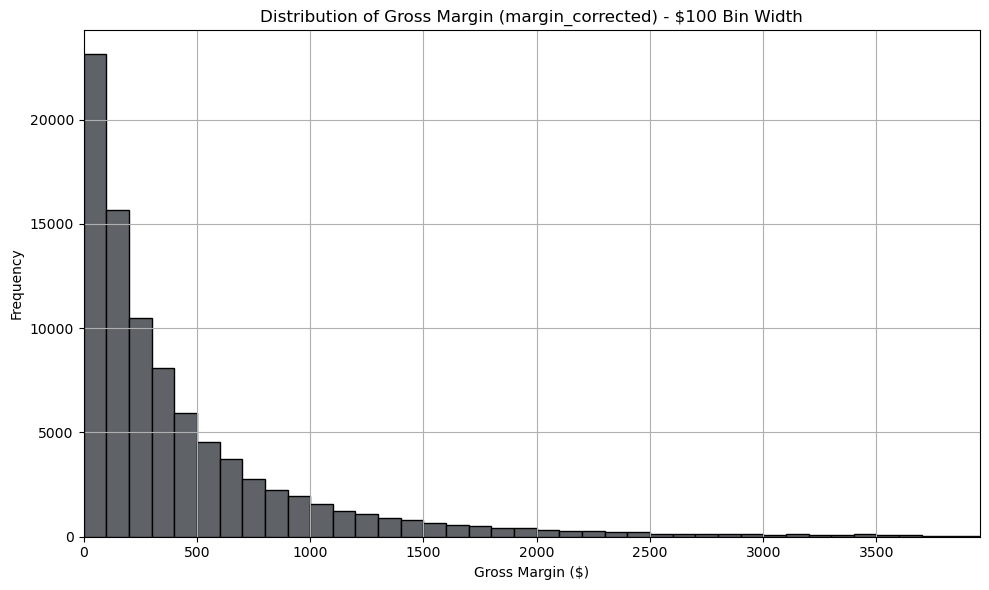

In [46]:
# Block 11
# Query to get margin_corrected values
query = """
    SELECT SAFE_CAST(margin_corrected AS FLOAT64) AS margin_corrected
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(margin_corrected AS FLOAT64) IS NOT NULL
"""

# Load the data into a DataFrame
df = client.query(query).to_dataframe()

# Define bins in $100 intervals, from 0 to 99th percentile
max_val = df['margin_corrected'].quantile(0.99)
bins = range(0, int(max_val) + 100, 100)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['margin_corrected'], bins=bins, edgecolor='black', color='#5f6368')
plt.title('Distribution of Gross Margin (margin_corrected) - $100 Bin Width')
plt.xlabel('Gross Margin ($)')
plt.ylabel('Frequency')
plt.xlim(0, max_val)  # Match x-axis to the 99th percentile
plt.grid(True)
plt.tight_layout()
plt.show()


count: 90088
mean: 272.24
median: 129.0
stddev: 388.51
min: 0
max: 6593
90th_percentile: 720.0
95th_percentile: 1007.0
99th_percentile: 1792.0
over_1_year: 25.09
over_2_years: 9.79


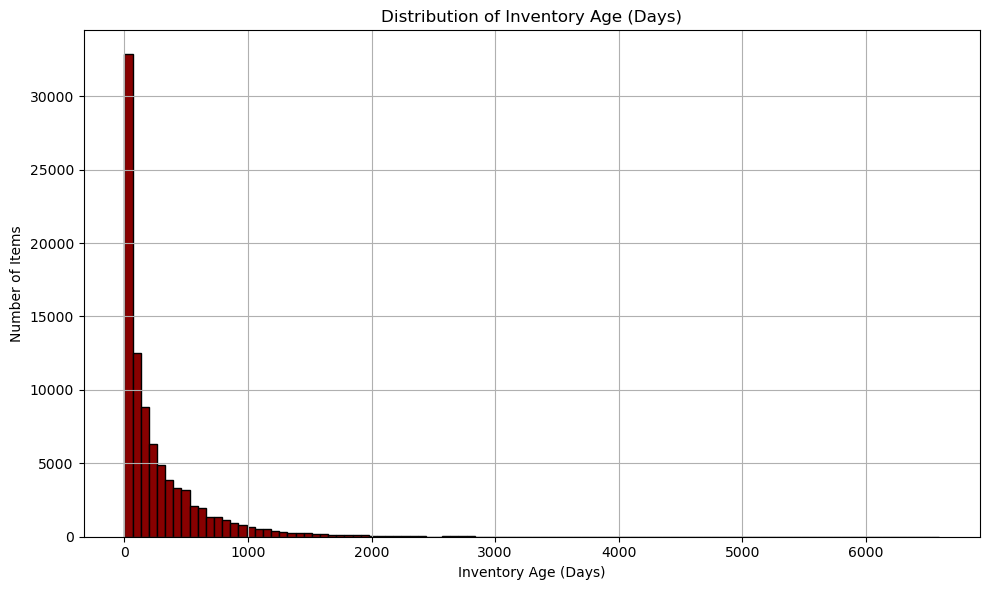

In [47]:
# Block 12
# Step 1: Load inventory age data
query = """
    SELECT SAFE_CAST(age_inventory_days AS INT64) AS age_days
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(age_inventory_days AS INT64) IS NOT NULL
"""
df = client.query(query).to_dataframe()

# Step 2: Filter out negative ages (data issues)
df = df[df['age_days'] >= 0]

# Step 3: Calculate robust summary statistics
age_stats = {
    "count": len(df),
    "mean": df['age_days'].mean(),
    "median": df['age_days'].median(),
    "stddev": df['age_days'].std(),
    "min": df['age_days'].min(),
    "max": df['age_days'].max(),
    "90th_percentile": df['age_days'].quantile(0.90),
    "95th_percentile": df['age_days'].quantile(0.95),
    "99th_percentile": df['age_days'].quantile(0.99),
    "over_1_year": (df['age_days'] > 365).mean() * 100,
    "over_2_years": (df['age_days'] > 730).mean() * 100
}

# Step 4: Print the stats
for k, v in age_stats.items():
    print(f"{k}: {round(v, 2)}")

# Step 5: Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['age_days'], bins=100, color='#880000', edgecolor='black')
plt.title("Distribution of Inventory Age (Days)")
plt.xlabel("Inventory Age (Days)")
plt.ylabel("Number of Items")
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
# Block 13
# Step 1: Query margin + key identifying fields
query = """
    SELECT 
        sku,
        vendor,
        style,
        category_name,
        SAFE_CAST(margin_corrected AS FLOAT64) AS margin_corrected,
        SAFE_CAST(margin_percent AS FLOAT64) AS margin_percent,
        SAFE_CAST(cost AS FLOAT64) AS cost,
        SAFE_CAST(saleprice AS FLOAT64) AS saleprice,
        SAFE_CAST(age_inventory_days AS INT64) AS age_inventory_days
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE SAFE_CAST(margin_corrected AS FLOAT64) IS NOT NULL
"""

df = client.query(query).to_dataframe()

# Step 2: Filter to only valid margin rows
df = df[df['margin_corrected'].notna()]

# Step 3: Calculate 90th percentile
margin_cutoff = df['margin_corrected'].quantile(0.90)
print(f"90th percentile gross margin: ${round(margin_cutoff, 2)}")

# Step 4: Filter top 10% margin items
top_10_margin_df = df[df['margin_corrected'] > margin_cutoff]

# Optional: Sort and preview
top_10_margin_df = top_10_margin_df.sort_values(by='margin_corrected', ascending=False)
print(top_10_margin_df.head(10))

# Optional: Export to CSV
# top_10_margin_df.to_csv("top_10_percent_margin_inventory.csv", index=False)


90th percentile gross margin: $1197.5
                   sku vendor                style  \
8554     003-105-03399    JDC            CU900DEF2   
8493     001-105-03345    XLD                70492   
29705    001-155-04392    JDC        LIGHTNING 700   
8704     002-105-01881    JDC  EXCEPTIONAL3.52FMPT   
35385    001-170-01558    GAB       BG3968-65W45JJ   
8529   001-105-3000002   PREM                 AR19   
8586   001-105-3000013    JDC       E3SEM400TPS090   
42821    001-270-00474    ATL                12194   
40655    001-230-01709    ADG           ADG913645V   
38101    001-200-03108    JYE              RB38504   

                       category_name  margin_corrected  margin_percent  \
8554                     Live Bridal         123055.64          0.4102   
8493                     Live Bridal          65100.00          0.3426   
29705                  Diamond Studs          55027.00          0.4046   
8704                     Live Bridal          37568.00          0.3795 

Number of categories that make up 80% of gross sales: 11


category_name  sale_total  cumulative_sales  \
0   Diamond Wedding Bands  -  Women's  5371265.21        5371265.21   
1            Diamond Engagement Rings  4914262.59       10285527.80   
2                       Diamond Studs  3495649.96       13781177.76   
3                               Watch  3388387.84       17169565.60   
4                         Live Bridal  3353807.11       20523372.71   
5                    Diamond Pendants  1910806.39       22434179.10   
6                   Diamond Bracelets  1629648.72       24063827.82   
7   Diamond Fashion Rings  -  Women's  1424570.50       25488398.32   
8                         Gold Chains  1405898.35       26894296.67   
9     Colored Stone Rings  -  Women's  1359167.02       28253463.69   
10       Gold Wedding Bands  -  Men's  1314879.18       29568342.87   
11                   Diamond Earrings  1265861.93       30834204.80   
12              Colored Stone Pendant   989005.16       31823209.96   
13           Colored Stones  -  Loose   797937.21       32621147.17   
14            Alternative Metal Bands   719422.19       33340569.36   

    cumulative_percent  
0            13.938283  
1            26.690656  
2            35.761770  
3            44.554541  
4            53.257576  
5            58.216065  
6            62.444958  
7            66.141679  
8            69.789945  
9            73.316946  
10           76.729020  
11           80.013896  
12           82.580337  
13           84.650962  
14           86.517842

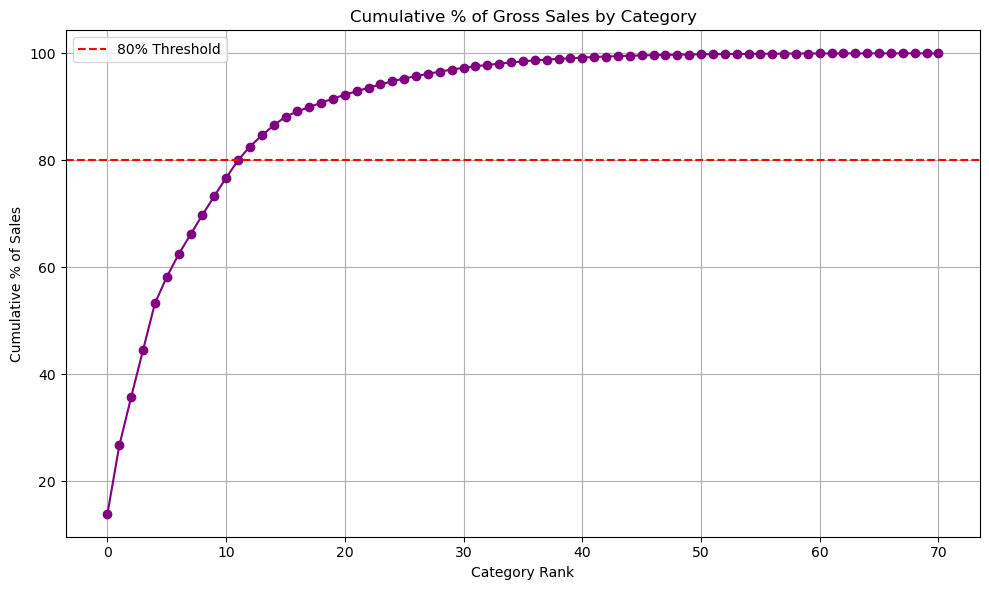

In [20]:
# Block 14
# Step 1: Query sales data by category
query = """
    SELECT 
        category_name,
        SAFE_CAST(sale_total AS FLOAT64) AS sale_total
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE category_name IS NOT NULL AND SAFE_CAST(sale_total AS FLOAT64) IS NOT NULL
"""
df = client.query(query).to_dataframe()

# Step 2: Aggregate sales by category
category_sales = df.groupby('category_name', as_index=False)['sale_total'].sum()

# Step 3: Sort by total sales descending
category_sales = category_sales.sort_values(by='sale_total', ascending=False).reset_index(drop=True)

# Step 4: Calculate cumulative sales and % of total
category_sales['cumulative_sales'] = category_sales['sale_total'].cumsum()
total_sales = category_sales['sale_total'].sum()
category_sales['cumulative_percent'] = category_sales['cumulative_sales'] / total_sales * 100

# Step 5: Identify categories contributing to 80% of total sales
top_categories = category_sales[category_sales['cumulative_percent'] <= 80]

# Display result
print(f"Number of categories that make up 80% of gross sales: {len(top_categories)}")
display(category_sales.head(15))  # View top categories and their % contributions

# Optional: Plot the Pareto curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(category_sales['cumulative_percent'], marker='o', color='purple')
plt.axhline(80, color='red', linestyle='--', label='80% Threshold')
plt.title('Cumulative % of Gross Sales by Category')
plt.xlabel('Category Rank')
plt.ylabel('Cumulative % of Sales')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


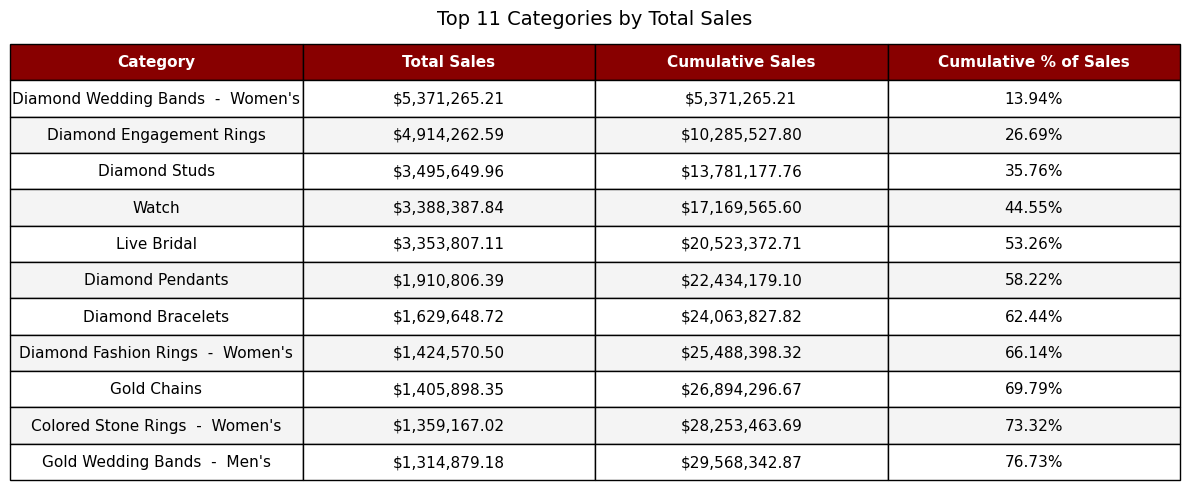

In [49]:
# Start with the top 11 categories
top11 = category_sales.head(11).copy()

# Keep relevant columns only
top11 = top11[['category_name', 'sale_total', 'cumulative_sales', 'cumulative_percent']].copy()

# Rename for presentation
top11.columns = ['Category', 'Total Sales', 'Cumulative Sales', 'Cumulative % of Sales']

# Format values
top11['Total Sales'] = top11['Total Sales'].apply(lambda x: f"${x:,.2f}")
top11['Cumulative Sales'] = top11['Cumulative Sales'].apply(lambda x: f"${x:,.2f}")
top11['Cumulative % of Sales'] = top11['Cumulative % of Sales'].apply(lambda x: f"{x:.2f}%")

# Plot table
fig, ax = plt.subplots(figsize=(12, 5))
ax.axis('off')
table = ax.table(
    cellText=top11.values,
    colLabels=top11.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Optional: Style headers and cells
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#880000')  # <- Maroon header
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')  # Zebra striping


plt.title("Top 11 Categories by Total Sales", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("top_11_categories_table.png", dpi=300, bbox_inches='tight')
plt.show()



#### Side-by-side comparison of Facebook Prophet model, and SARIMA model
Import prophet and statsmodel for SARIMA

In [50]:
!pip install prophet

In [51]:
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [52]:
query = """
SELECT *
FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
LIMIT 5
"""

df = client.query(query).to_dataframe()
print(df.columns)

Index(['category_num', 'category_name', 'period', 'forecasted_sales',
       'forecasted_sales_lower', 'forecasted_sales_upper'],
      dtype='object')


In [53]:
query = """
SELECT 
  sold_date AS ds,
  SAFE_CAST(sale_total AS FLOAT64) AS y
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE category_name = 'Live Bridal'
  AND sold_date IS NOT NULL
  AND SAFE_CAST(sale_total AS FLOAT64) IS NOT NULL
ORDER BY ds
"""
df = client.query(query).to_dataframe()
df['ds'] = pd.to_datetime(df['ds']).dt.to_period('M').dt.to_timestamp()  # Resample to monthly if needed
df = df.groupby('ds', as_index=False)['y'].sum()
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)



14:11:32 - cmdstanpy - INFO - Chain [1] start processing


14:11:32 - cmdstanpy - INFO - Chain [1] done processing


           ds           yhat     yhat_lower     yhat_upper
59 2025-01-01   63605.271076   33994.057228   93830.758538
60 2025-02-01   38185.928428    6666.179350   70364.085317
61 2025-03-01   68234.343701   37512.978603   99878.077915
62 2025-04-01   47562.230508   16646.188501   77485.392163
63 2025-05-01   53447.986907   22718.124909   84868.122719
64 2025-06-01   49609.233416   19568.026397   82045.600128
65 2025-07-01   53160.495008   23183.073359   82582.903809
66 2025-08-01   66444.542351   35669.728039   98366.834399
67 2025-09-01   51394.962395   20079.488785   82534.516360
68 2025-10-01   86325.971911   57875.867626  119220.902694
69 2025-11-01   63283.212393   31565.842128   94062.689907
70 2025-12-01  143092.849119  112469.645217  172607.701552


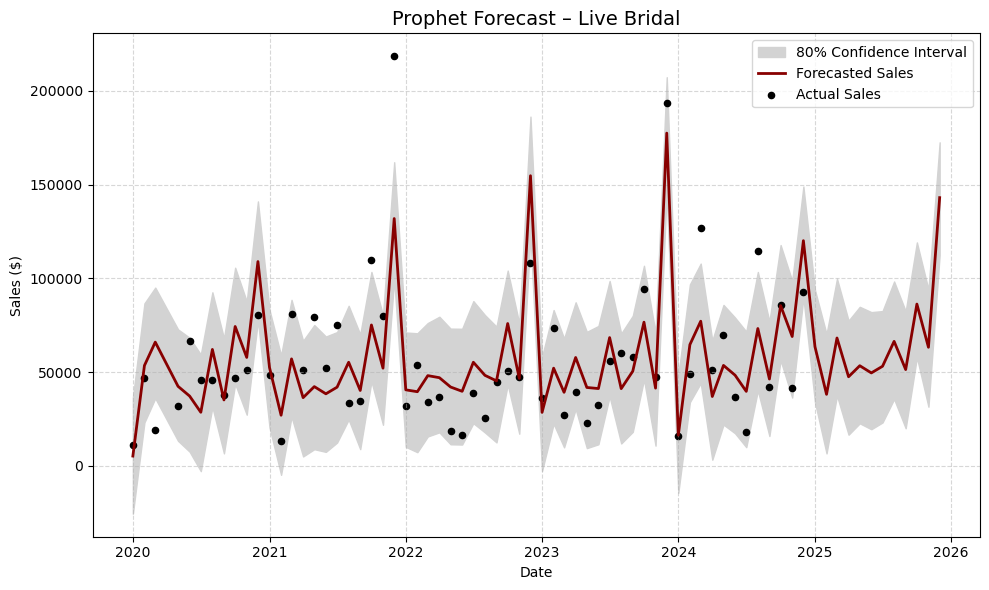

In [54]:

# Remove timezone from ds
df['ds'] = pd.to_datetime(df['ds']).dt.tz_localize(None)

# Initialize and fit Prophet model
model_prophet = Prophet()
model_prophet.fit(df)

# Make future dataframe and forecast
future = model_prophet.make_future_dataframe(periods=12, freq='MS')
forecast_prophet = model_prophet.predict(future)

# Filter only forecasted months (optional preview)
latest_ds = pd.to_datetime(df['ds'].max())
forecast_only = forecast_prophet[forecast_prophet['ds'] > latest_ds][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
print(forecast_only)

# --- CUSTOM STYLED PLOT USING JDC COLORS ---
fig, ax = plt.subplots(figsize=(10, 6))

# Confidence interval in light gray
ax.fill_between(
    forecast_prophet['ds'],
    forecast_prophet['yhat_lower'],
    forecast_prophet['yhat_upper'],
    color='lightgray',
    label='80% Confidence Interval'
)

# Forecasted trend in maroon
ax.plot(
    forecast_prophet['ds'],
    forecast_prophet['yhat'],
    color='#880000',  # Maroon
    linewidth=2,
    label='Forecasted Sales'
)

# Actual data as black dots
ax.scatter(df['ds'], df['y'], color='black', s=20, label='Actual Sales')

# Final plot formatting
ax.set_title("Prophet Forecast – Live Bridal", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Sales ($)")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()
fig.tight_layout()

plt.show()


In [55]:
# Evaluate Prophet
# Ensure both 'ds' columns are datetime64[ns]
df['ds'] = pd.to_datetime(df['ds'])
forecast_prophet['ds'] = pd.to_datetime(forecast_prophet['ds'])

# Now merge safely
df_eval_prophet = pd.merge(df, forecast_prophet[['ds', 'yhat']], on='ds', how='left')

# Calculate metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

mape_prophet = mean_absolute_percentage_error(df_eval_prophet['y'], df_eval_prophet['yhat']) * 100
rmse_prophet = np.sqrt(mean_squared_error(df_eval_prophet['y'], df_eval_prophet['yhat']))

print(f"📊 Prophet Performance (In-Sample):")
print(f"MAPE: {mape_prophet:.2f}%")
print(f"RMSE: ${rmse_prophet:,.2f}")

📊 Prophet Performance (In-Sample):
MAPE: 41.36%
RMSE: $24,017.56


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47780D+00    |proj g|=  3.61164D-02

At iterate    5    f=  9.45607D+00    |proj g|=  1.66566D-02

At iterate   10    f=  9.45455D+00    |proj g|=  1.56087D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   9.167D-06   9.455D+00
  F =   9.4545492119833252     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
           ds           yhat    yhat_lower     yhat_upper
0  2025-01-0

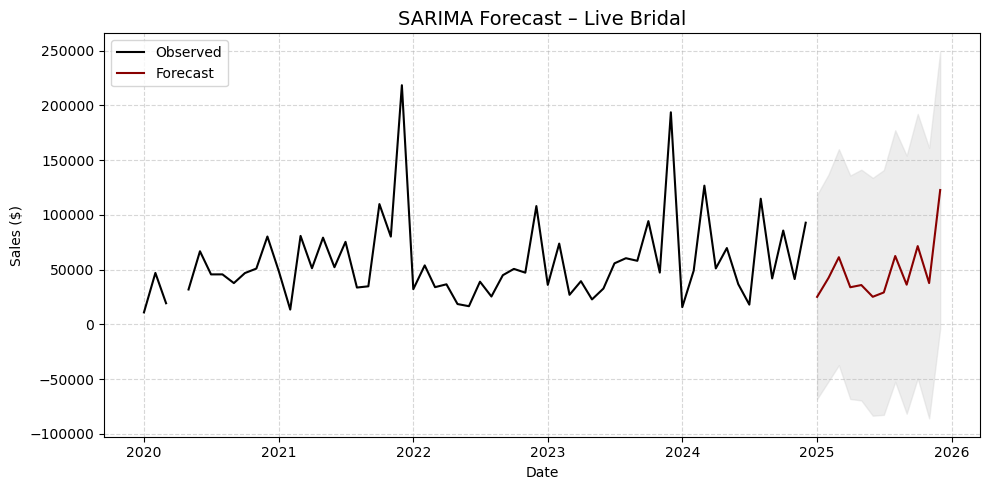

In [56]:
# Forecast with SARIMA

# Set datetime index and frequency
df_sarima = df.set_index('ds').asfreq('MS')

# Fit SARIMA model
model_sarima = SARIMAX(df_sarima['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
results_sarima = model_sarima.fit()

# Forecast next 12 months
forecast_sarima = results_sarima.get_forecast(steps=12)
predicted_mean = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Combine forecast into a single DataFrame
df_sarima_forecast = predicted_mean.to_frame(name='yhat')
df_sarima_forecast['yhat_lower'] = conf_int.iloc[:, 0]
df_sarima_forecast['yhat_upper'] = conf_int.iloc[:, 1]
df_sarima_forecast.index.name = 'ds'
df_sarima_forecast.reset_index(inplace=True)

# (Optional) Print or export
print(df_sarima_forecast)
# df_sarima_forecast.to_csv("live_bridal_sarima_forecast.csv", index=False)

# Plot SARIMA forecast with JDC colors
plt.figure(figsize=(10, 5))

# Observed data (default blue or set to black if preferred)
plt.plot(df_sarima['y'], label='Observed', color='black')

# Forecasted line in maroon
plt.plot(predicted_mean.index, predicted_mean, label='Forecast', color='#880000')

# Confidence interval in light gray
plt.fill_between(
    predicted_mean.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='lightgray',
    alpha=0.4
)

# Formatting
plt.legend()
plt.title("SARIMA Forecast – Live Bridal", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Evaluate the forecasting performance of the above models using two common metrics:
    
MAPE (Mean Absolute Percentage Error)	Measures average absolute percent error. Easy to interpret — “X% off on average.”
RMSE (Root Mean Squared Error)	Penalizes large errors more than MAPE. Good when large spikes are important.

In [57]:
# Evaluate SARIMA

# Predict in-sample values from SARIMA
sarima_fitted = results_sarima.fittedvalues

# Align actuals with fitted values
df_eval_sarima = df_sarima.copy()
df_eval_sarima['yhat'] = sarima_fitted

# Drop missing values from early differencing periods
df_eval_sarima = df_eval_sarima.dropna()

# Calculate metrics
mape_sarima = mean_absolute_percentage_error(df_eval_sarima['y'], df_eval_sarima['yhat']) * 100
rmse_sarima = np.sqrt(mean_squared_error(df_eval_sarima['y'], df_eval_sarima['yhat']))

print(f"\n📊 SARIMA Performance (In-Sample):")
print(f"MAPE: {mape_sarima:.2f}%")
print(f"RMSE: ${rmse_sarima:,.2f}")



📊 SARIMA Performance (In-Sample):
MAPE: 72.52%
RMSE: $37,952.59


In [58]:
# Fine-tuneing the SARIMA Model

import itertools
import warnings

warnings.filterwarnings("ignore")

# Parameter ranges to test
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12  # monthly seasonality

# Create all combinations of SARIMA parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

# Grid search
best_aic = float('inf')
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(
                df_sarima['y'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except:
            continue

print(f"Best SARIMA params: Order={best_params[0]}, Seasonal Order={best_params[1]} with AIC={best_aic:.2f}")



Best SARIMA params: Order=(2, 2, 2), Seasonal Order=(1, 1, 0, 12) with AIC=778.29


In [59]:
# Unpack best parameters from tuning step
order_opt, seasonal_order_opt = best_params

# Refit with tuned parameters
model_sarima = SARIMAX(
    df_sarima['y'],
    order=order_opt,
    seasonal_order=seasonal_order_opt
)
results_sarima = model_sarima.fit()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31591D+00    |proj g|=  1.04836D-01

At iterate    5    f=  9.26992D+00    |proj g|=  4.88834D-03

At iterate   10    f=  9.26880D+00    |proj g|=  2.74602D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     14      1     0     0   9.712D-06   9.269D+00
  F =   9.2688040296811884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


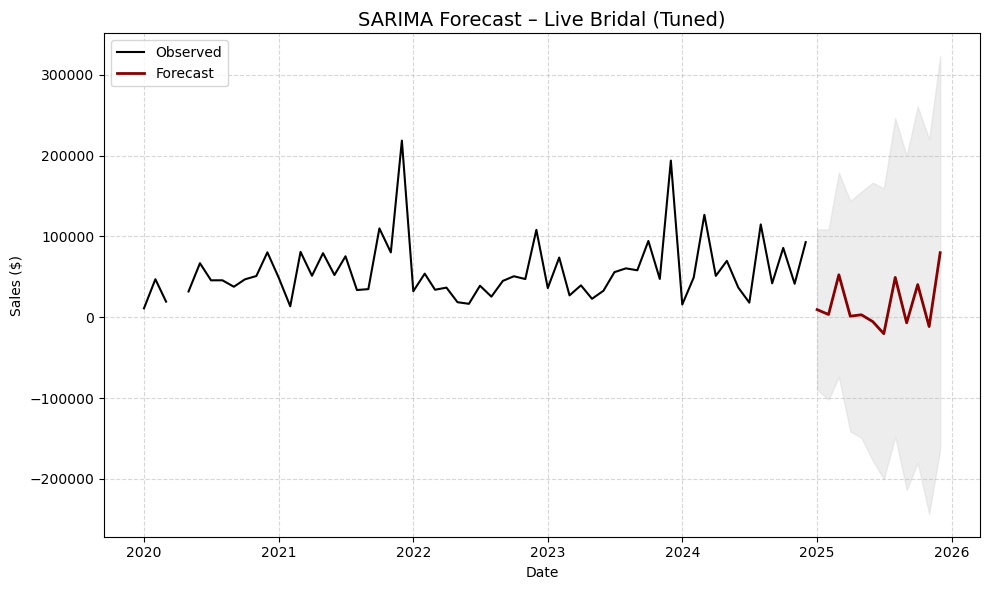

MAPE (in-sample): 77.74%
RMSE (in-sample): $39,420.96


In [60]:
# --- Forecast the next 12 months ---
forecast_sarima = results_sarima.get_forecast(steps=12)
predicted_mean = forecast_sarima.predicted_mean
conf_int = forecast_sarima.conf_int()

# Combine forecast into DataFrame
df_sarima_forecast = predicted_mean.to_frame(name='yhat')
df_sarima_forecast['yhat_lower'] = conf_int.iloc[:, 0]
df_sarima_forecast['yhat_upper'] = conf_int.iloc[:, 1]
df_sarima_forecast.index.name = 'ds'
df_sarima_forecast.reset_index(inplace=True)

# --- Plot with JDC Colors ---
plt.figure(figsize=(10, 6))

# Observed: Black line
plt.plot(df_sarima.index, df_sarima['y'], label='Observed', color='black')

# Forecast: Maroon line
plt.plot(predicted_mean.index, predicted_mean, label='Forecast', color='#880000', linewidth=2)

# Confidence interval: Light gray shading
plt.fill_between(
    predicted_mean.index,
    conf_int.iloc[:, 0],
    conf_int.iloc[:, 1],
    color='lightgray',
    alpha=0.4
)

# Styling
plt.title("SARIMA Forecast – Live Bridal (Tuned)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# --- Evaluate Model Performance: MAPE and RMSE ---

# In-sample prediction
in_sample_pred = results_sarima.get_prediction(start=df_sarima.index[0], end=df_sarima.index[-1])
y_true = df_sarima['y']
y_pred = in_sample_pred.predicted_mean

# Combine into a single DataFrame and drop NaNs
eval_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
eval_df.dropna(inplace=True)

# Calculate MAPE and RMSE
mape = mean_absolute_percentage_error(eval_df['y_true'], eval_df['y_pred']) * 100
rmse = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))

print(f"MAPE (in-sample): {mape:.2f}%")
print(f"RMSE (in-sample): ${rmse:,.2f}")


Loop through top 11 categories.

In [63]:
# Check column names for debugging
query = """
    SELECT *
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    LIMIT 5
"""
sample_df = client.query(query).to_dataframe()
print(sample_df.columns)


Index(['category_num', 'category_name', 'period', 'forecasted_sales',
       'forecasted_sales_lower', 'forecasted_sales_upper'],
      dtype='object')


🔄 Running forecast for: Colored Stone Rings  -  Women's


14:27:15 - cmdstanpy - INFO - Chain [1] start processing
14:27:15 - cmdstanpy - INFO - Chain [1] done processing


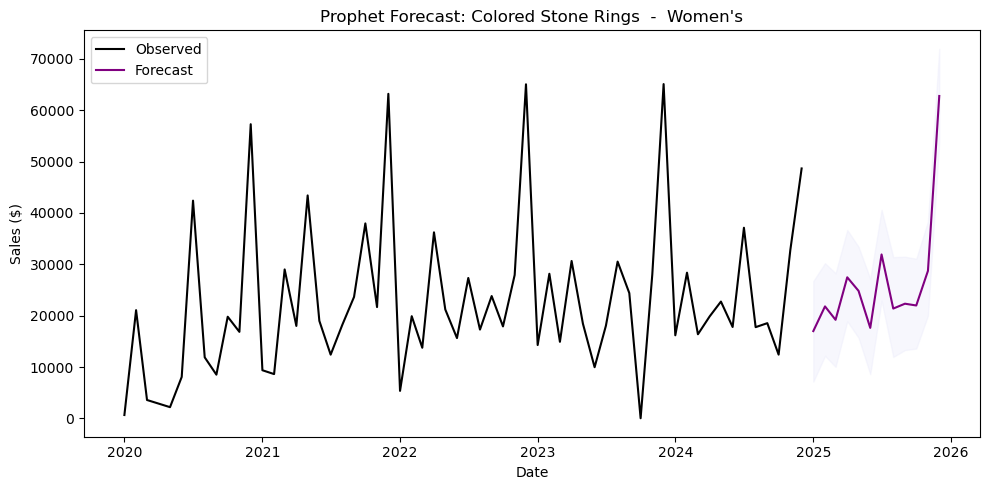

🔄 Running forecast for: Diamond Bracelets


14:27:18 - cmdstanpy - INFO - Chain [1] start processing
14:27:18 - cmdstanpy - INFO - Chain [1] done processing


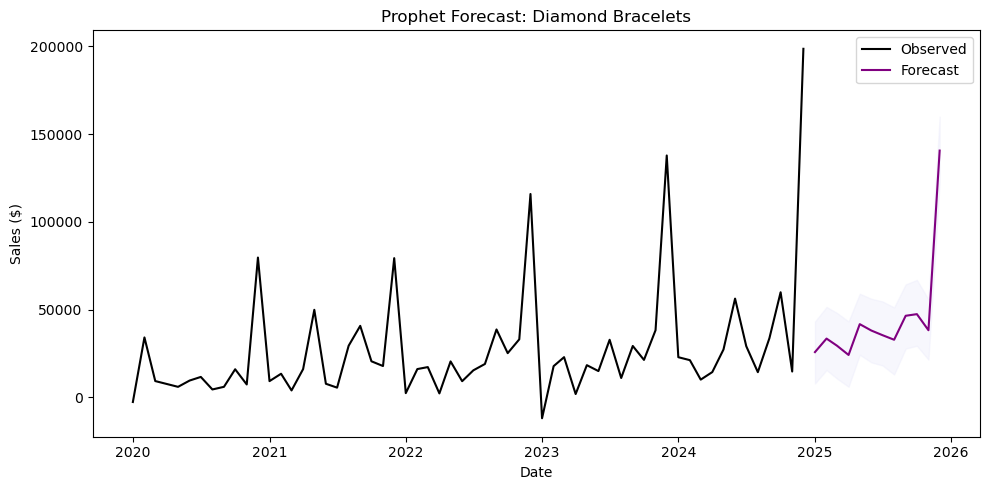

🔄 Running forecast for: Diamond Engagement Rings


14:27:20 - cmdstanpy - INFO - Chain [1] start processing
14:27:20 - cmdstanpy - INFO - Chain [1] done processing


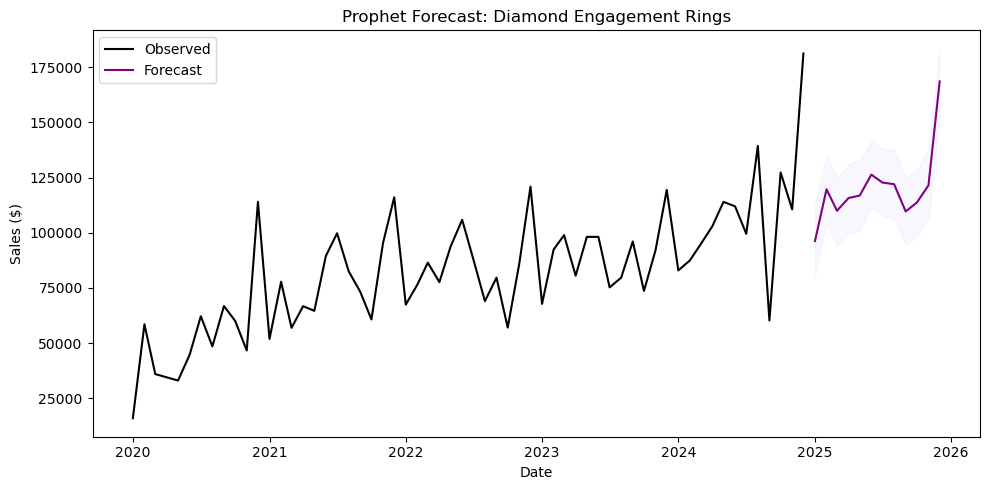

🔄 Running forecast for: Diamond Fashion Rings  -  Women's


14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing


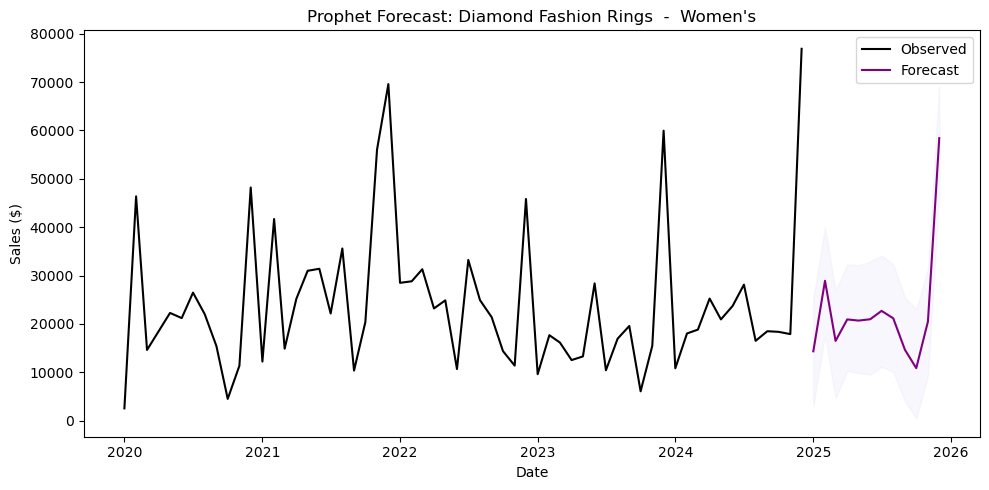

🔄 Running forecast for: Diamond Pendants


14:27:27 - cmdstanpy - INFO - Chain [1] start processing
14:27:27 - cmdstanpy - INFO - Chain [1] done processing


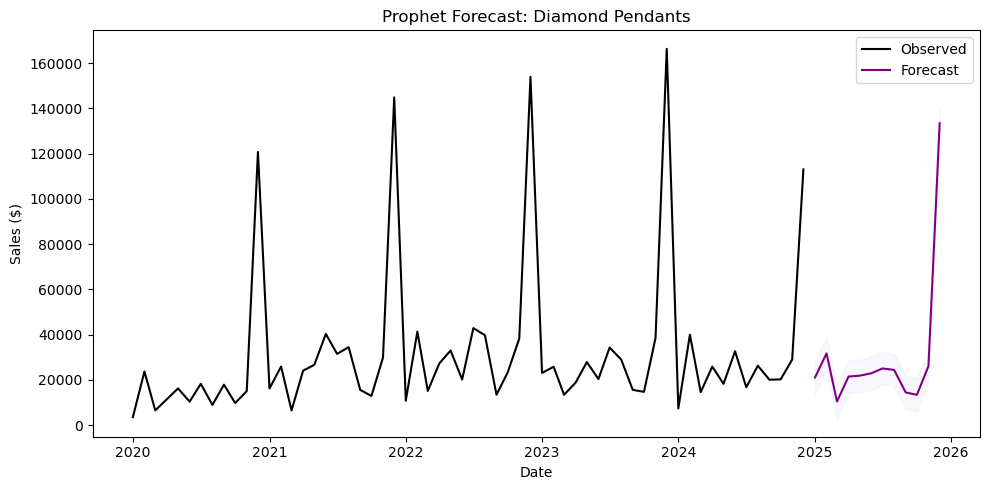

🔄 Running forecast for: Diamond Studs


14:27:30 - cmdstanpy - INFO - Chain [1] start processing
14:27:30 - cmdstanpy - INFO - Chain [1] done processing


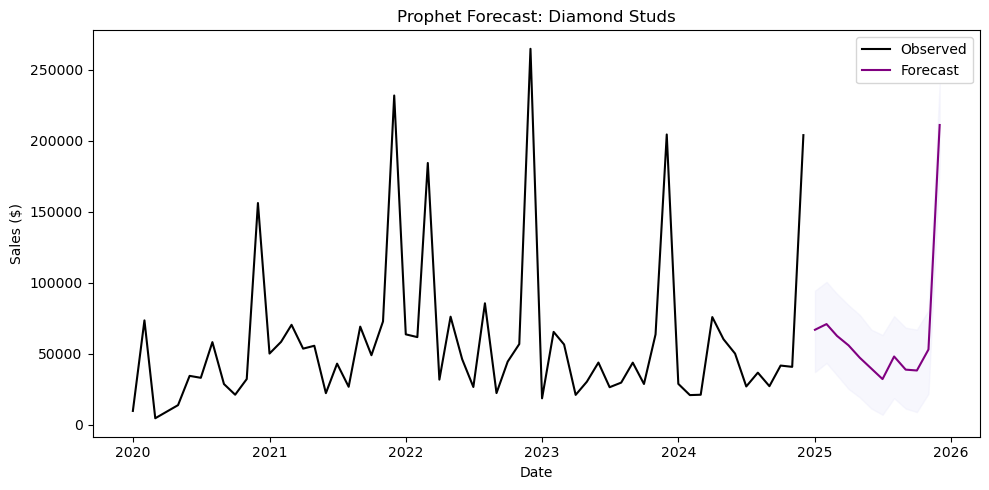

🔄 Running forecast for: Diamond Wedding Bands  -  Women's


14:27:33 - cmdstanpy - INFO - Chain [1] start processing
14:27:33 - cmdstanpy - INFO - Chain [1] done processing


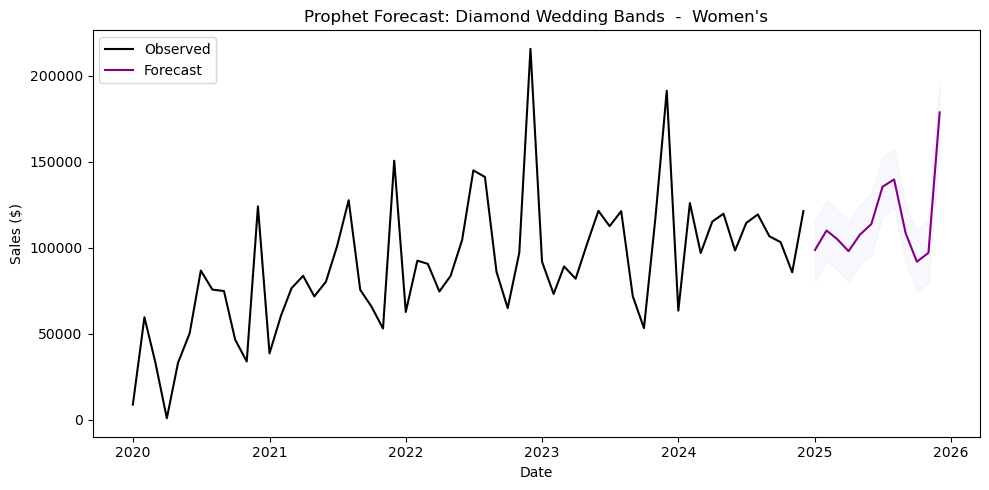

🔄 Running forecast for: Gold Chains


14:27:36 - cmdstanpy - INFO - Chain [1] start processing
14:27:36 - cmdstanpy - INFO - Chain [1] done processing


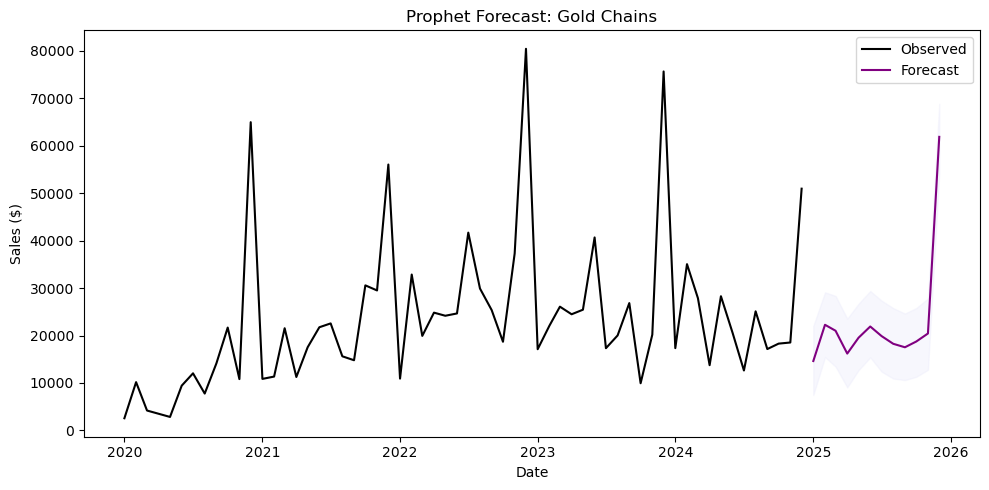

🔄 Running forecast for: Gold Wedding Bands  -  Men's


14:27:39 - cmdstanpy - INFO - Chain [1] start processing
14:27:39 - cmdstanpy - INFO - Chain [1] done processing


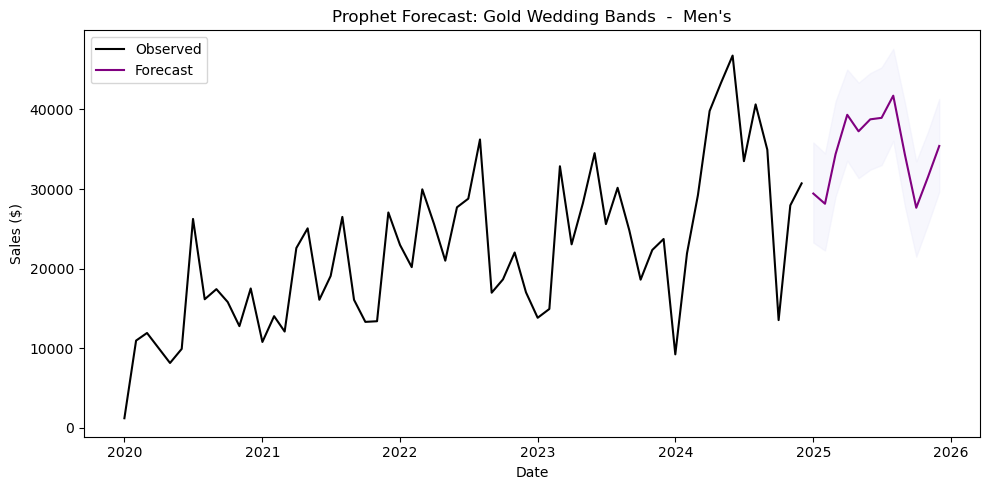

🔄 Running forecast for: Live Bridal


14:27:42 - cmdstanpy - INFO - Chain [1] start processing
14:27:42 - cmdstanpy - INFO - Chain [1] done processing


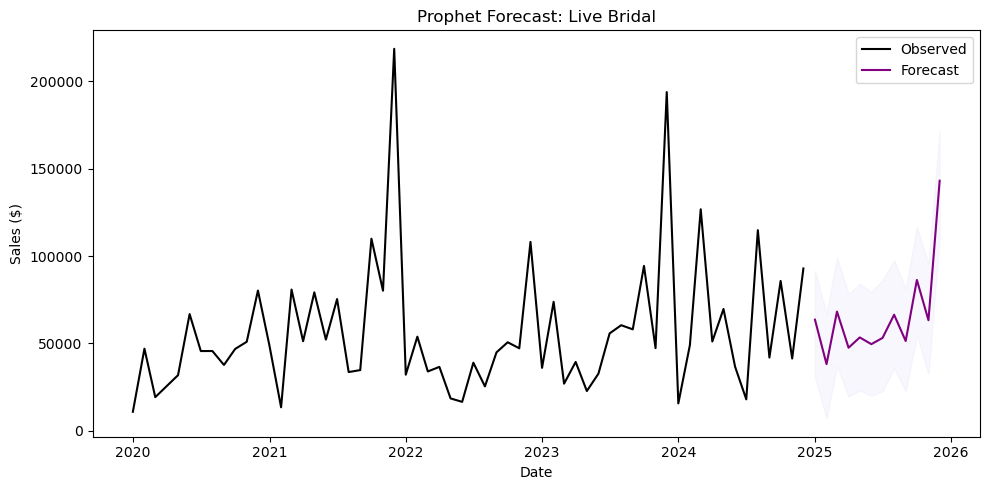

🔄 Running forecast for: Watch


14:27:45 - cmdstanpy - INFO - Chain [1] start processing
14:27:45 - cmdstanpy - INFO - Chain [1] done processing


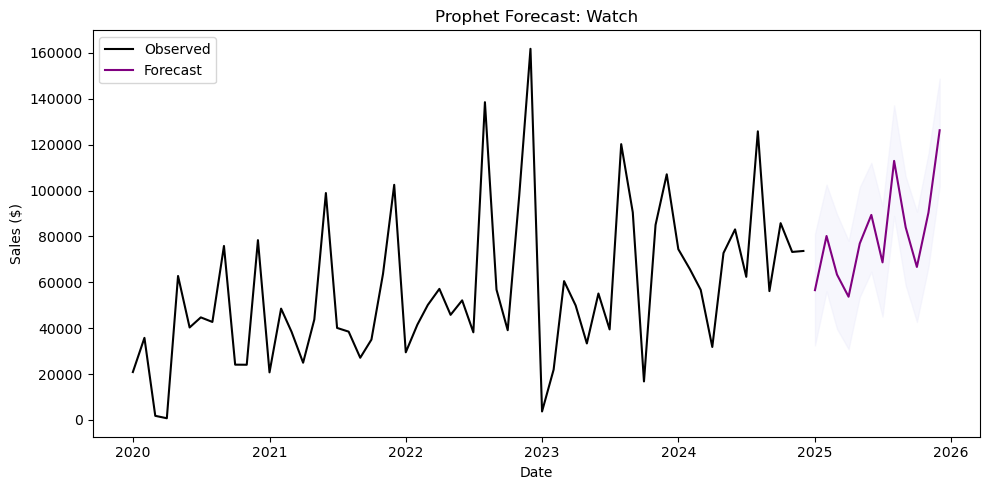

In [65]:
# Step 1: Get list of unique category names
query = """
    SELECT DISTINCT category_name
    FROM `capstone-project-2025-449217.jdc_data.forecast_sales`
    ORDER BY category_name
"""
categories = client.query(query).to_dataframe()

# Step 2: Loop through each category and forecast with Prophet
all_forecasts = []

for _, row in categories.iterrows():
    category_name = row['category_name']
    print(f"🔄 Running forecast for: {category_name}")

    # Escape single quotes for safe SQL
    safe_category = category_name.replace("'", "\\'")

    # Query the data for this category
    query = f"""
        SELECT 
            period AS ds,
            total_sales AS y
        FROM `capstone-project-2025-449217.jdc_data.forecast_sales`
        WHERE category_name = "{safe_category}"
        ORDER BY ds
    """
    
    try:
        df = client.query(query).to_dataframe()
    except Exception as e:
        print(f"❌ Failed to query data for {category_name}: {e}")
        continue

    df['ds'] = pd.to_datetime(df['ds'])

    if len(df) < 24:
        print(f"⚠️ Skipping {category_name} — not enough data ({len(df)} rows)")
        continue

    # Fit Prophet model
    model = Prophet()
    model.fit(df)

    future = model.make_future_dataframe(periods=12, freq='MS')
    forecast = model.predict(future)

    # Filter forecasted months only
    latest_ds = df['ds'].max()
    future_forecast = forecast[forecast['ds'] > latest_ds][
        ['ds', 'yhat', 'yhat_lower', 'yhat_upper']
    ].copy()
    future_forecast['category_name'] = category_name

    all_forecasts.append(future_forecast)

    # Optional plot
    plt.figure(figsize=(10, 5))
    plt.plot(df['ds'], df['y'], label='Observed', color='black')
    plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast', color='purple')
    plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'],
                     color='lavender', alpha=0.3)
    plt.title(f"Prophet Forecast: {category_name}")
    plt.xlabel("Date")
    plt.ylabel("Sales ($)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Step 3: Combine all forecasts into one DataFrame
forecast_results = pd.concat(all_forecasts, ignore_index=True)


Aggregated sales model.

14:29:10 - cmdstanpy - INFO - Chain [1] start processing
14:29:10 - cmdstanpy - INFO - Chain [1] done processing


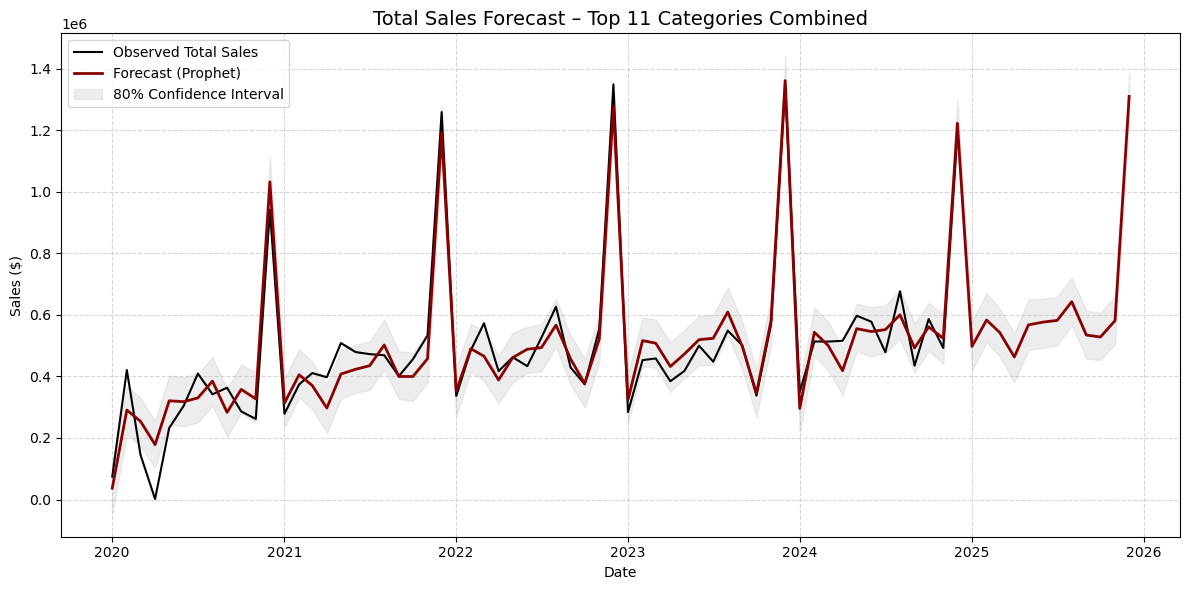

In [66]:
# Query aggregated sales
query = """
SELECT 
  DATE_TRUNC(sold_date, MONTH) AS ds,
  SUM(SAFE_CAST(sale_total AS FLOAT64)) AS y
FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
WHERE category_name IN (
  SELECT category_name
  FROM (
    SELECT category_name,
           SUM(SAFE_CAST(sale_total AS FLOAT64)) AS total_sales
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE category_name IS NOT NULL
    GROUP BY category_name
    ORDER BY total_sales DESC
    LIMIT 11
  )
)
AND sold_date IS NOT NULL
GROUP BY ds
ORDER BY ds
"""
agg_df = client.query(query).to_dataframe()
agg_df['ds'] = pd.to_datetime(agg_df['ds']).dt.tz_localize(None)

from prophet import Prophet

model = Prophet()
model.fit(agg_df)

future = model.make_future_dataframe(periods=12, freq='MS')
forecast = model.predict(future)

# --- Custom Styled Plot (JDC Theme) ---
plt.figure(figsize=(12, 6))

# Observed actual sales: black
plt.plot(agg_df['ds'], agg_df['y'], label='Observed Total Sales', color='black')

# Prophet forecast: maroon
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast (Prophet)', color='#880000', linewidth=2)

# Confidence interval: light gray
plt.fill_between(
    forecast['ds'],
    forecast['yhat_lower'],
    forecast['yhat_upper'],
    color='lightgray',
    alpha=0.4,
    label='80% Confidence Interval'
)

# Labels and styling
plt.title("Total Sales Forecast – Top 11 Categories Combined", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Sales ($)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [67]:
# Sort and ensure datetime format
agg_df = agg_df.sort_values("ds")
agg_df["ds"] = pd.to_datetime(agg_df["ds"])

# Train/test split (e.g., last 12 months as test)
train = agg_df[agg_df["ds"] < "2024-01-01"]
test = agg_df[agg_df["ds"] >= "2024-01-01"]

# Fit SARIMA model
sarima_model = SARIMAX(
    train["y"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast for the test period
n_periods = len(test)
sarima_forecast = sarima_model.forecast(steps=n_periods)

# Evaluate SARIMA
mape_sarima = mean_absolute_percentage_error(test["y"], sarima_forecast) * 100
rmse_sarima = np.sqrt(mean_squared_error(test["y"], sarima_forecast))

print(f"📊 SARIMA Performance:")
print(f"MAPE: {mape_sarima:.2f}%")
print(f"RMSE: ${rmse_sarima:,.2f}")

# Prophet Comparison (optional, if needed)
prophet = Prophet()
prophet.fit(train.rename(columns={"ds": "ds", "y": "y"}))

future = prophet.make_future_dataframe(periods=n_periods, freq="MS")
forecast_prophet = prophet.predict(future)

# Align Prophet forecast with test period
prophet_forecast = forecast_prophet[forecast_prophet["ds"].isin(test["ds"])]

# Evaluate Prophet
mape_prophet = mean_absolute_percentage_error(test["y"], prophet_forecast["yhat"]) * 100
rmse_prophet = np.sqrt(mean_squared_error(test["y"], prophet_forecast["yhat"]))

print(f"\n📊 Prophet Performance:")
print(f"MAPE: {mape_prophet:.2f}%")
print(f"RMSE: ${rmse_prophet:,.2f}")


14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing


📊 SARIMA Performance:
MAPE: 16.44%
RMSE: $118,634.02

📊 Prophet Performance:
MAPE: 15.13%
RMSE: $96,598.91


In [68]:
import plotly.graph_objects as go

# Your evaluation results
mape_prophet = 15.13
rmse_prophet = 96599.05

mape_sarima = 16.44
rmse_sarima = 118634.02

# Create DataFrame
results_df = pd.DataFrame({
    "Metric": ["MAPE", "RMSE"],
    "Prophet": [f"{mape_prophet:.2f}%", f"${rmse_prophet:,.2f}"],
    "SARIMA": [f"{mape_sarima:.2f}%", f"${rmse_sarima:,.2f}"]
})

# Use Plotly for polished table
fig = go.Figure(data=[
    go.Table(
        header=dict(
            values=["<b>Metric</b>", "<b>Prophet</b>", "<b>SARIMA</b>"],
            fill_color="#f0f0f0",
            align="center",
            font=dict(size=14, color="black"),
            line_color="darkgray"
        ),
        cells=dict(
            values=[results_df[col] for col in results_df.columns],
            fill_color="white",
            align="center",
            font=dict(size=13),
            height=30
        )
    )
])

fig.update_layout(
    title_text="<b>Evaluation Metrics:</b>",
    title_x=0.5,
    margin=dict(t=60, b=20),
    height=300
)

fig.show()


Inventory Forecasting - Using the Value-Based Approach for Inventory

Step 1: Create a new table with the aggregated forecast values and save it to GBQ

In [69]:
# Select only relevant columns
forecast_export = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

# Optional: Rename for clarity
forecast_export.rename(columns={
    'ds': 'period',
    'yhat': 'forecasted_sales',
    'yhat_lower': 'forecasted_sales_lower',
    'yhat_upper': 'forecasted_sales_upper'
}, inplace=True)

# Define destination table
table_id = "capstone-project-2025-449217.jdc_data.agg_forecast_sales"

# Upload to BigQuery
job = client.load_table_from_dataframe(forecast_export, table_id, job_config=bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE"  # Overwrite if exists
))
job.result()  # Wait for job to complete

print("✅ Forecast results successfully written to BigQuery!")


✅ Forecast results successfully written to BigQuery!


In [86]:
# Step 1: Query both datasets from BigQuery
# --- Inventory Query ---
inventory_query = """
SELECT 
  CAST(category_name AS STRING) AS category_name,
  ROUND(SUM(CAST(cost AS FLOAT64)), 2) AS inventory_value
FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
WHERE sold_status = 0
  AND category_name IS NOT NULL
GROUP BY category_name
"""

# --- Forecast Query ---
forecast_query = """
SELECT 
  CAST(category_name AS STRING) AS category_name,
  ROUND(SUM(forecasted_sales) / 12, 2) AS avg_monthly_sales
FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
WHERE EXTRACT(YEAR FROM period) = 2025
GROUP BY category_name
"""

# Step 1: Load query results
inventory_df = client.query(inventory_query).to_dataframe()
forecast_df = client.query(forecast_query).to_dataframe()

# Step 2: Ensure matching data types
inventory_df['category_name'] = inventory_df['category_name'].astype(str)
forecast_df['category_name'] = forecast_df['category_name'].astype(str)

# Step 3: Merge the data
combined_df = pd.merge(forecast_df, inventory_df, on="category_name", how="left")


# Step 4: Sort (optional)
combined_df = combined_df.sort_values(by="inventory_value", ascending=False)


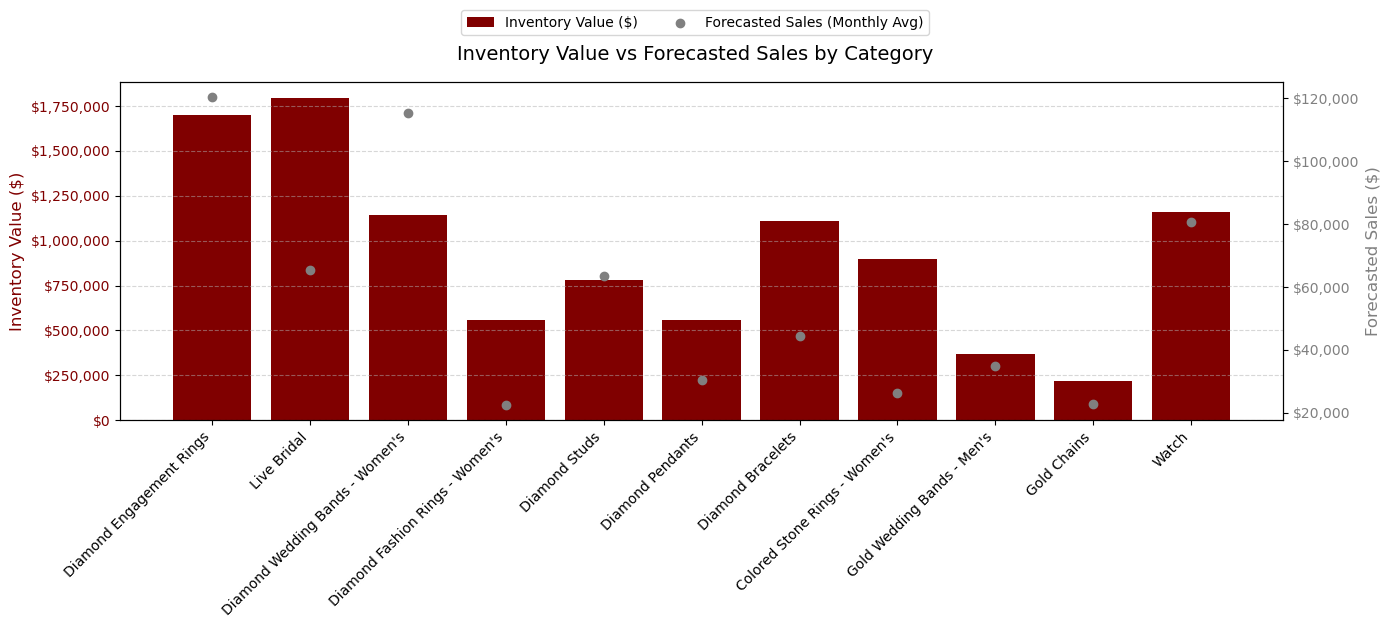

In [91]:
# Set up figure and axes
fig, ax1 = plt.subplots(figsize=(14, 6))
x = range(len(merged_df))

# Bar: Inventory Value (maroon)
ax1.bar(x, merged_df['total_sale_value'], color='#800000', label='Inventory Value ($)')
ax1.set_ylabel('Inventory Value ($)', fontsize=12, color='#800000')
ax1.tick_params(axis='y', labelcolor='#800000')
ax1.set_xticks(x)
ax1.set_xticklabels(merged_df['category_name'], rotation=45, ha='right')
ax1.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Dot: Forecasted Monthly Sales (gray)
ax2 = ax1.twinx()
ax2.scatter(x, merged_df['avg_monthly_forecasted_sales'], color='gray', label='Forecasted Sales (Monthly Avg)', zorder=5)
ax2.set_ylabel('Forecasted Sales ($)', fontsize=12, color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Title and grid
fig.suptitle('Inventory Value vs Forecasted Sales by Category', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout()
plt.show()

In [34]:
from pandas_gbq import to_gbq

to_gbq(
    forecast_results,
    destination_table='jdc_data.top11_forecast_sales',
    project_id='capstone-project-2025-449217',
    if_exists='replace'
)


100%|██████████| 1/1 [00:00<00:00, 9986.44it/s]


In [71]:
# Step 1: Merge forecast with actual sales (agg_df)
full_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
full_forecast = full_forecast.merge(agg_df[['ds', 'y']], on='ds', how='left')

# Step 2: Rename for clarity
full_forecast.rename(columns={
    'ds': 'period',
    'yhat': 'forecasted_sales',
    'yhat_lower': 'forecasted_sales_lower',
    'yhat_upper': 'forecasted_sales_upper',
    'y': 'actual_sales'
}, inplace=True)

# Step 3: Define table name
table_id = "capstone-project-2025-449217.jdc_data.agg_forecast_sales"

# Step 4: Upload to BigQuery
from google.cloud import bigquery

job_config = bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
job = client.load_table_from_dataframe(full_forecast, table_id, job_config=job_config)
job.result()  # Waits for the job to finish

print("✅ Forecast + actuals table successfully written to BigQuery!")


✅ Forecast + actuals table successfully written to BigQuery!


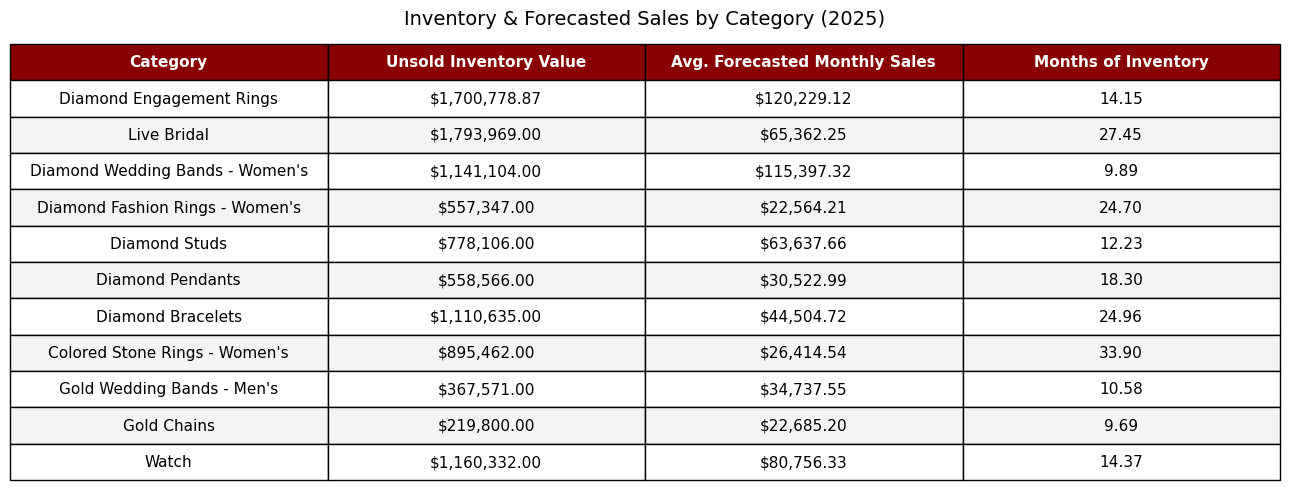

In [93]:
# STEP 1: Load inventory data (unsold inventory value by category)
inventory_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      ROUND(SUM(saleprice), 2) AS total_sale_value
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE sold_status = 0
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, category_name
"""
inventory_df = client.query(inventory_query).to_dataframe()

# STEP 2: Load 2025 forecasted sales data by category
forecast_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      period,
      forecasted_sales
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    WHERE CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
      AND EXTRACT(YEAR FROM period) = 2025
"""
forecast_df = client.query(forecast_query).to_dataframe()

# STEP 3: Calculate average monthly forecasted sales for each category
monthly_forecast = (
    forecast_df
    .groupby('category_num')['forecasted_sales']
    .mean()
    .reset_index()
    .rename(columns={'forecasted_sales': 'avg_monthly_forecasted_sales'})
)

# STEP 4: Merge forecast with inventory
merged_df = inventory_df.merge(monthly_forecast, on='category_num', how='left')

# STEP 5: Calculate months of inventory by value
merged_df['months_of_inventory'] = (
    merged_df['total_sale_value'] / merged_df['avg_monthly_forecasted_sales']
).round(2)

# DO NOT format merged_df here — wait until report_df is created

import matplotlib.pyplot as plt

# STEP 6: Create a clean display version for your report
report_df = merged_df[[
    'category_name',
    'total_sale_value',
    'avg_monthly_forecasted_sales',
    'months_of_inventory'
]].copy()

report_df.columns = [
    "Category",
    "Unsold Inventory Value",
    "Avg. Forecasted Monthly Sales",
    "Months of Inventory"
]

# STEP 7: Apply formatting (on this display-only DataFrame)
report_df["Unsold Inventory Value"] = report_df["Unsold Inventory Value"].apply(lambda x: f"${x:,.2f}")
report_df["Avg. Forecasted Monthly Sales"] = report_df["Avg. Forecasted Monthly Sales"].apply(lambda x: f"${x:,.2f}")
report_df["Months of Inventory"] = report_df["Months of Inventory"].apply(lambda x: f"{x:,.2f}")

# STEP 8: Plot the table using matplotlib
fig, ax = plt.subplots(figsize=(13, 5))
ax.axis('off')

table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style headers and rows
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#880000')
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')

# STEP 9: Add title and export
plt.title("Inventory & Forecasted Sales by Category (2025)", fontsize=14, pad=20)
plt.tight_layout()
plt.savefig("forecast_inventory_table.png", dpi=300, bbox_inches='tight')
plt.show()




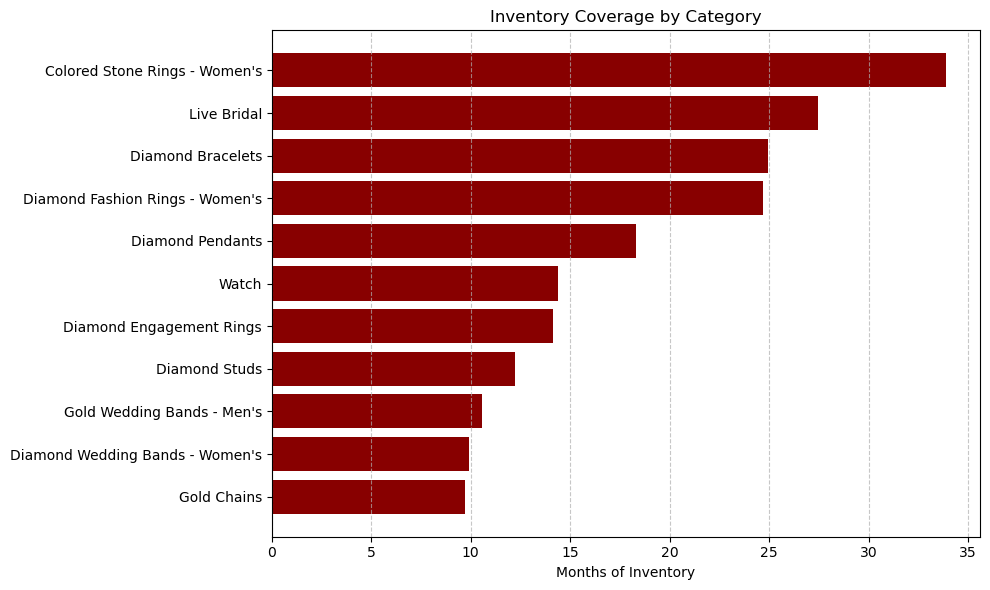

In [94]:
# Convert months_of_inventory back to float for plotting if needed
merged_df['months_of_inventory'] = merged_df['months_of_inventory'].astype(float)

# Sort by months_of_inventory
plot_df = merged_df.sort_values(by='months_of_inventory', ascending=True)

# Create the plot
plt.figure(figsize=(10, 6))
plt.barh(plot_df['category_name'], plot_df['months_of_inventory'], color='#880000')
plt.xlabel("Months of Inventory")
plt.title("Inventory Coverage by Category")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


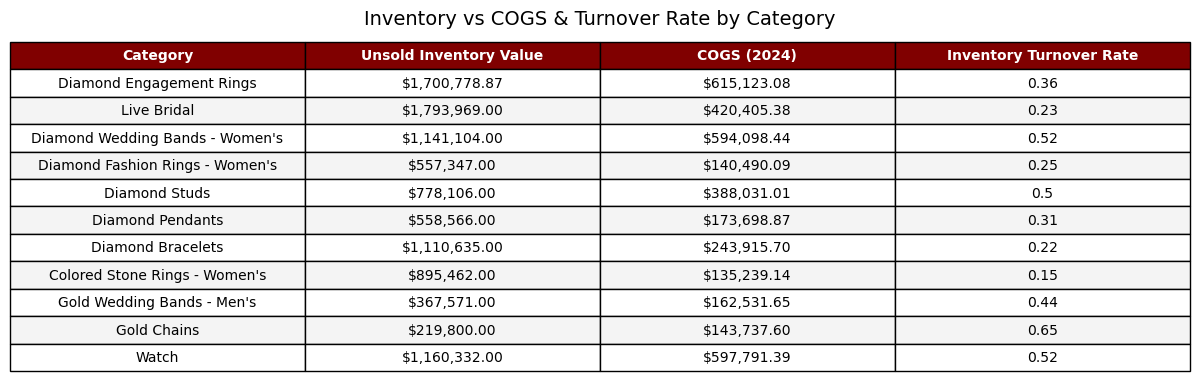

In [97]:
# STEP 1: Load unsold inventory value by category
inventory_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      ROUND(SUM(saleprice), 2) AS total_sale_value
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE sold_status = 0
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, category_name
"""
inventory_df = client.query(inventory_query).to_dataframe()

# STEP 2: Load 2025 forecasted sales data by category
forecast_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      period,
      forecasted_sales
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    WHERE EXTRACT(YEAR FROM period) = 2025
"""
forecast_df = client.query(forecast_query).to_dataframe()

# STEP 3: Average monthly forecasted sales
monthly_forecast = (
    forecast_df
    .groupby('category_num')['forecasted_sales']
    .mean()
    .reset_index()
    .rename(columns={'forecasted_sales': 'avg_monthly_forecasted_sales'})
)

# STEP 4: Load 2024 COGS for turnover calculation
cogs_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      ROUND(SUM(cogs), 2) AS total_cogs
    FROM `capstone-project-2025-449217.jdc_data.filtered_retail_sales`
    WHERE EXTRACT(YEAR FROM sold_date) = 2024
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num
"""
cogs_df = client.query(cogs_query).to_dataframe()

# STEP 5: Merge all data together
merged_df = (
    inventory_df
    .merge(monthly_forecast, on='category_num', how='left')
    .merge(cogs_df, on='category_num', how='left')
)

# STEP 6: Calculate KPIs
merged_df['months_of_inventory'] = (
    merged_df['total_sale_value'] / merged_df['avg_monthly_forecasted_sales']
).round(2)

merged_df['inventory_turnover'] = (
    merged_df['total_cogs'] / merged_df['total_sale_value']
).round(2)

# STEP 7: Format columns
merged_df['total_sale_value'] = merged_df['total_sale_value'].map('${:,.2f}'.format)
merged_df['avg_monthly_forecasted_sales'] = merged_df['avg_monthly_forecasted_sales'].map('${:,.2f}'.format)
merged_df['total_cogs'] = merged_df['total_cogs'].map('${:,.2f}'.format)

# STEP 8: Reorder and filter for report
report_df = merged_df[[
    'category_name',
    'total_sale_value',
    'total_cogs',
    'inventory_turnover'
]].rename(columns={
    'category_name': 'Category',
    'total_sale_value': 'Unsold Inventory Value',
    'total_cogs': 'COGS (2024)',
    'inventory_turnover': 'Inventory Turnover Rate'
})

# STEP 9: Display simplified table
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

table = ax.table(
    cellText=report_df.values,
    colLabels=report_df.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.05, 2)

# Apply styling: Maroon header, alternating row colors
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#800000')  # JDC maroon
    else:
        cell.set_facecolor('#F4F4F4' if row % 2 == 0 else '#FFFFFF')

plt.title("Inventory vs COGS & Turnover Rate by Category", fontsize=14, pad=40)
plt.tight_layout()
plt.savefig("inventory_turnover_summary.png", dpi=300, bbox_inches='tight')
plt.show()


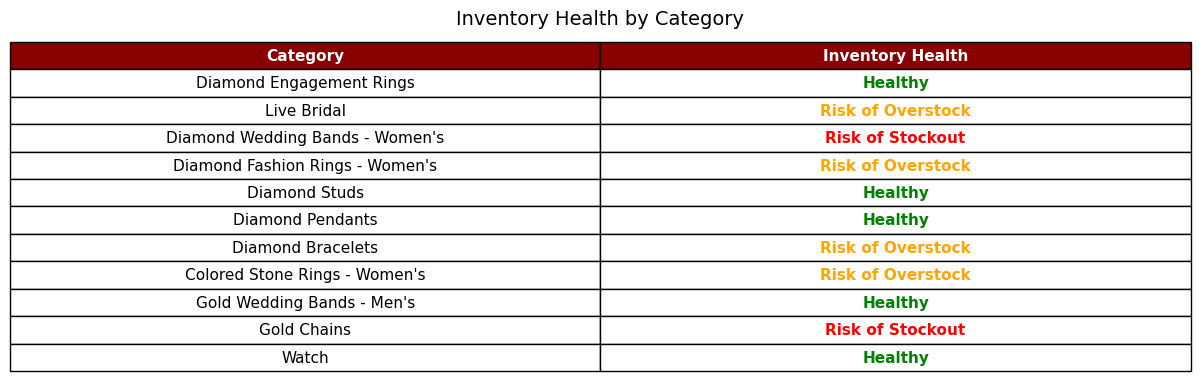

In [123]:
# STEP 1: Create simplified table
health_only_df = health_df[['category_name', 'Inventory Health']].copy()
health_only_df.columns = ['Category', 'Inventory Health']

# STEP 2: Icon-only or keep labels
icon_map = {
    '✅ Healthy': 'Healthy',
    '⚠️ Risk of Overstock': 'Risk of Overstock',
    '🚨 Risk of Stockout': 'Risk of Stockout'
}
health_only_df['Inventory Health'] = health_only_df['Inventory Health'].map(icon_map)

# STEP 3: Create table
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('off')

table = ax.table(
    cellText=health_only_df.values,
    colLabels=health_only_df.columns,
    loc='center',
    cellLoc='center',
    colLoc='center'
)

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 2)

# STEP 4: Style header
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight='bold', color='white')
        cell.set_facecolor('#880000')  # JDC maroon

# STEP 5: Style individual cells based on content
for row_idx in range(1, len(health_only_df) + 1):
    health = health_only_df.iloc[row_idx - 1]['Inventory Health']
    cell = table[row_idx, 1]

    if 'Healthy' in health:
        cell.get_text().set_color('green')
        cell.get_text().set_weight('bold')
    elif 'Overstock' in health:
        cell.get_text().set_color('orange')
        cell.get_text().set_weight('bold')
    elif 'Stockout' in health:
        cell.get_text().set_color('red')
        cell.get_text().set_weight('bold')

# STEP 6: Title & export
plt.title("Inventory Health by Category", fontsize=14, pad=40)
plt.tight_layout()
plt.savefig("inventory_health_colored.png", dpi=300, bbox_inches='tight')
plt.show()

#### Calculating Open-To-Buy
By Q1 and by Full Year (2025)

In [124]:

# STEP 1: Load unsold inventory value by category (Beginning Inventory)
inventory_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      category_name,
      ROUND(SUM(saleprice), 2) AS total_sale_value
    FROM `capstone-project-2025-449217.jdc_data.filtered_inventory`
    WHERE sold_status = 0
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, category_name
"""
inventory_df = client.query(inventory_query).to_dataframe()

# STEP 2: Load forecasted sales for Q1 2025
forecast_query = """
    SELECT
      CAST(category_num AS STRING) AS category_num,
      EXTRACT(QUARTER FROM period) AS quarter,
      SUM(forecasted_sales) AS quarterly_forecasted_sales
    FROM `capstone-project-2025-449217.jdc_data.top11_forecast_sales`
    WHERE EXTRACT(YEAR FROM period) = 2025
      AND EXTRACT(QUARTER FROM period) = 1
      AND CAST(category_num AS STRING) IN ('100', '105', '110', '130', '155', '160', '170', '200', '405', '430', '560')
    GROUP BY category_num, quarter
"""
forecast_df = client.query(forecast_query).to_dataframe()

# STEP 3: Merge forecast with inventory (only category_num is shared)
merged_df = inventory_df.merge(forecast_df, on='category_num', how='left')

# STEP 4: Calculate Open-to-Buy
merged_df['open_to_buy'] = merged_df['quarterly_forecasted_sales'] - merged_df['total_sale_value']

# STEP 5: Format columns
merged_df['total_sale_value'] = merged_df['total_sale_value'].map('${:,.2f}'.format)
merged_df['quarterly_forecasted_sales'] = merged_df['quarterly_forecasted_sales'].map('${:,.2f}'.format)
merged_df['open_to_buy'] = merged_df['open_to_buy'].map('${:,.2f}'.format)

# STEP 6: Select and rename final columns
otb_table = merged_df[[
    'category_name',
    'total_sale_value',
    'quarterly_forecasted_sales',
    'open_to_buy'
]].rename(columns={
    'category_name': 'Category',
    'total_sale_value': 'Beginning Inventory (Unsold)',
    'quarterly_forecasted_sales': 'Forecasted Sales (Q1)',
    'open_to_buy': 'Open to Buy'
})

# STEP 7: Display
print(otb_table)


                           Category Beginning Inventory (Unsold)  \
0          Diamond Engagement Rings                $1,700,778.87   
1                       Live Bridal                $1,793,969.00   
2   Diamond Wedding Bands - Women's                $1,141,104.00   
3   Diamond Fashion Rings - Women's                  $557,347.00   
4                     Diamond Studs                  $778,106.00   
5                  Diamond Pendants                  $558,566.00   
6                 Diamond Bracelets                $1,110,635.00   
7     Colored Stone Rings - Women's                  $895,462.00   
8        Gold Wedding Bands - Men's                  $367,571.00   
9                       Gold Chains                  $219,800.00   
10                            Watch                $1,160,332.00   

   Forecasted Sales (Q1)     Open to Buy  
0            $325,881.51  $-1,374,897.36  
1            $170,025.54  $-1,623,943.46  
2            $313,928.81    $-827,175.19  
3          

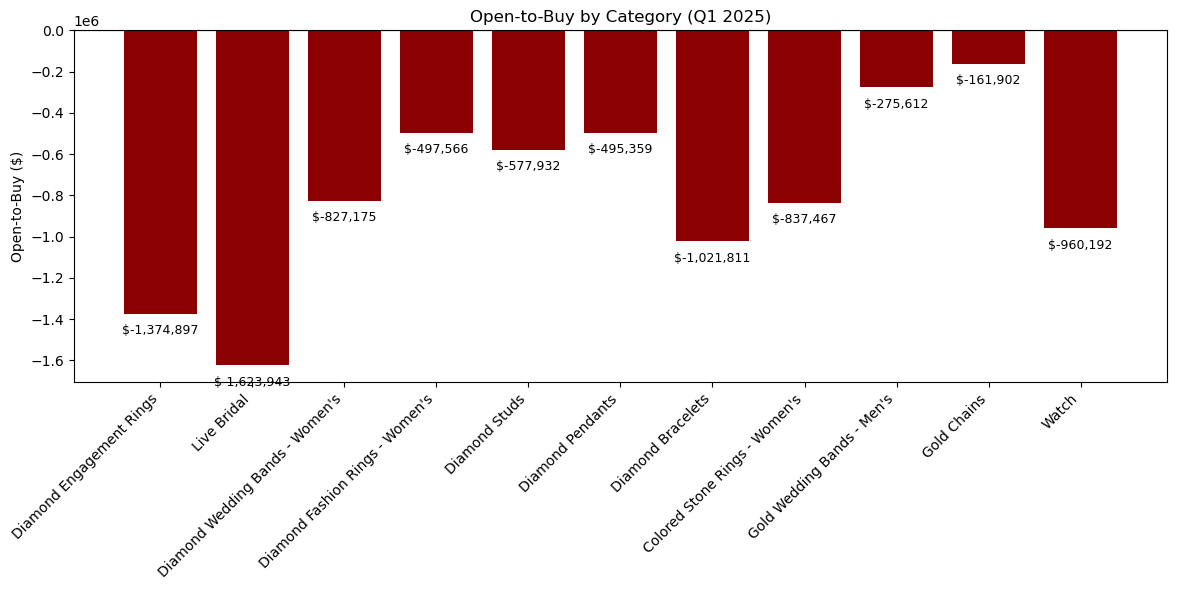

In [125]:
# Step 1: Convert formatted strings back to numeric
plot_df = merged_df.copy()
plot_df['quarterly_forecasted_sales'] = plot_df['quarterly_forecasted_sales'].replace('[\$,]', '', regex=True).astype(float)
plot_df['total_sale_value'] = plot_df['total_sale_value'].replace('[\$,]', '', regex=True).astype(float)
plot_df['open_to_buy'] = plot_df['open_to_buy'].replace('[\$,]', '', regex=True).astype(float)

# Step 2: Plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = plot_df['open_to_buy'].apply(lambda x: 'green' if x > 0 else 'darkred')

bars = ax.bar(
    plot_df['category_name'],
    plot_df['open_to_buy'],
    color=colors
)

# Labels and title
ax.set_ylabel("Open-to-Buy ($)")
ax.set_title("Open-to-Buy by Category (Q1 2025)")
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xticks(range(len(plot_df)))
ax.set_xticklabels(plot_df['category_name'], rotation=45, ha='right')

# Annotate values
for bar, val in zip(bars, plot_df['open_to_buy']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + (5000 if val > 0 else -50000),
            f"${val:,.0f}", ha='center', va='bottom' if val > 0 else 'top', fontsize=9)

plt.tight_layout()
plt.show()


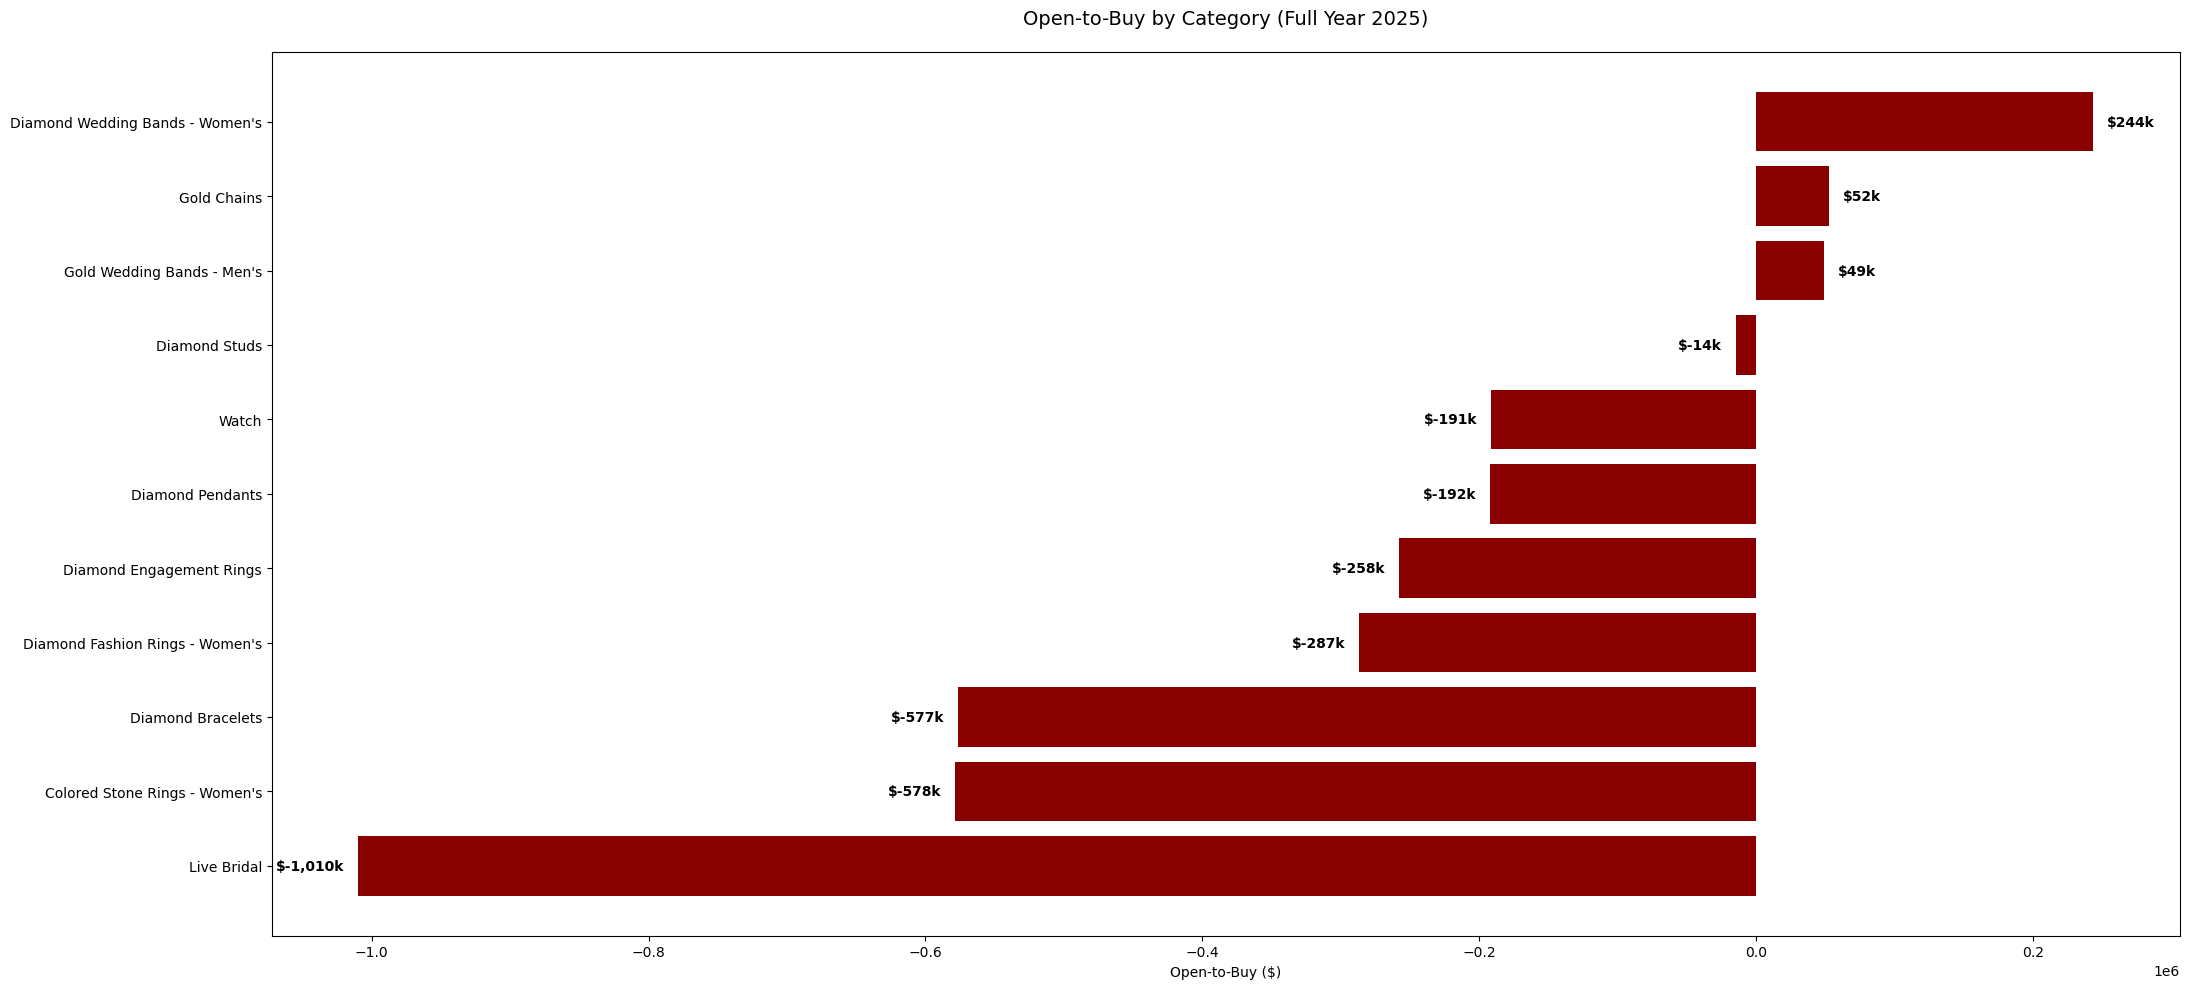

In [145]:
# Plot OTB for Full Year

# Sort by OTB for visual clarity
plot_df = merged_df.copy()
plot_df['open_to_buy'] = plot_df['open_to_buy'].replace('[\$,]', '', regex=True).astype(float)
plot_df = plot_df.sort_values('open_to_buy')

# Increase figure size (especially width)
fig, ax = plt.subplots(figsize=(22, 10))  # Wider than before

# Plot horizontal bars
bars = ax.barh(plot_df['category_name'], plot_df['open_to_buy'], color='#880000')

# Shortened value labels like $244k
for bar in bars:
    xval = bar.get_width()
    label = f"${xval/1000:,.0f}k"
    xpos = xval + 10000 if xval >= 0 else xval - 10000
    ha = 'left' if xval >= 0 else 'right'
    ax.text(xpos, bar.get_y() + bar.get_height()/2, label,
            ha=ha, va='center', fontsize=10, fontweight='bold')

# Title and labels
ax.set_title("Open-to-Buy by Category (Full Year 2025)", fontsize=14, pad=20)
ax.set_xlabel("Open-to-Buy ($)")

# Make room for long category names
plt.subplots_adjust(left=0.3)  # More space on left side
plt.tight_layout()
plt.savefig("open_to_buy_wider_chart.png", dpi=300, bbox_inches='tight')
plt.show()
